# Case Description

Source: https://www.enisa.europa.eu/topics/trainings-for-cybersecurity-specialists/online-training-material/technical-operational/#Forensic_analysis_Local_Incident_Response

Synopsis:  
The customer’s organization has found out that some of its sensitive data has been detected in an online text
sharing application.  
Due to the legal obligations and for business continuity purposes the CSIRT team has been tasked to conduct an incident response and incident investigation to mitigate the threats. 
The breach contains sensitive data and includes a threat notice that in a short while more data will follow. 
As the breach leads to a specific employee’s computer then CSIRT team, tasked to investigate the incident, follows the leads.  


# Objectives and Methodology


The goal is to uncover as much as possible the threat actor activities ("when, what, who, where, how"):
- the start date of the breach
- the vector of compromise
- the actions performed post-compromise
- the privilege escalations if any
- the backdoors created (persistence) if any
- the lateral movements if any
- the connections with C2 (command and controls) if any
- the data exfiltrated

To answers these questions, we will exclusively use exploratory methods and visualization to spot and correlate anomalies. 
Nevertheless, we will mount the disk to sometimes validate our findings. 
Ideally, we will ends up with a comprehensive timeline of events, keeping the most significant ones regarding the breach.

We focus on temporal artifacts on the disk. For this Windows 10 machine, the data selected are:
- the MFT stores all creation and modification of files and directories
- the Windows events (.evtx files) records some system, applications and users activities depending on the audit policies configured
- the prefetchs records binaries execution together with modules loaded
- the Web history and cache contain information about the recent browsing of users
- the SRUM database stores regularly application and network usage
- Windows registries embed many artifacts related to execution, persistence, files accessed, ...
- Windows Shell Items prove file access or execution


In a forensic investigation, the artifacts are not limited to the list above: we scan the disk with some Yara rules and antivirus, we analyze the memory, and depending on the file system, there are many other traces to look at. 
The ENISA training goes through all the steps.
This showcase delibarately deals with a subset.

Table of Contents (reader can jump straight to Conclusion on the Case to get only final visualizations):
- Data Overview and Preparation
- Reducing the Time Frame
- First Indicator(s) Hunting
- Taking a Step Back
- Disk Timeline on August 16th
- Taking a Step Back
- Beginning of the attack
- Xtreme RAT C2
- Lateral Movement
- Data Exfiltration
- Conclusion on the Case
- Conclusion on Pandas

We initiate the variable __answers__ to store our understanding as we progress, as well as create a pretty print function for it.

In [1]:
answers = {
    'start': [],
    'vector': [],
    'privesc': [],
    'persistence': [],
    'post_compromise': [],
    'lateral_movement': [],
    'c2': [],
    'data': [],
}

In [2]:
def display_answers(answers):
    flattened = [{'category': key, 'description': value} for key, values in answers.items() for value in values]
    return pd.DataFrame(flattened)

# Data Overview and Preparation

In data science, the first job is to prepare the data, also called data wrangling:
- ensure they have the appropriate type for their analysis
- decide what to do with missing data
- enrich the data if needed
- aggregate some other if needed

We start by instructing Jupyter to not hyperlink the URLs (we might find malicious ones ... we don't want a missclick becoming another breach !)

In [3]:
# we load all the needed modules and set usual options
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import scipy as sp
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
sns.set()

pd.options.display.float_format = '{:.6f}'.format
pd.set_option('max_colwidth', 500)

In [4]:
# we load the data
df = pd.read_json('case_1/events_light.ndjson', lines=True, convert_dates=False)

# reorder the columns
columns = [
    'datetime', 'source', 'raw', 'fair_tags',
    'size_bytes', 'bytes_received', 'bytes_sent',
    'evtx_info', 'data_type', 'timestamp', 'timestamp_desc'
]
df = df[columns]

# display structure of the dataframe
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562567 entries, 0 to 562566
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   datetime        562567 non-null  object 
 1   source          562567 non-null  object 
 2   raw             562567 non-null  object 
 3   fair_tags       562567 non-null  object 
 4   size_bytes      507264 non-null  float64
 5   bytes_received  1862 non-null    float64
 6   bytes_sent      1862 non-null    float64
 7   evtx_info       562567 non-null  object 
 8   data_type       16357 non-null   object 
 9   timestamp       562567 non-null  float64
 10  timestamp_desc  523621 non-null  object 
dtypes: float64(4), object(7)
memory usage: 345.8 MB


In [5]:
df.shape

(562567, 11)

In [6]:
df.head()

,datetime,source,raw,fair_tags,size_bytes,bytes_received,bytes_sent,evtx_info,data_type,timestamp,timestamp_desc
0,1970-01-01T00:00:00+00:00,reg_userassist,[HKEY_CURRENT_USER\Software\Microsoft\Windows\CurrentVersion\Explorer\UserAssist\{CEBFF5CD-ACE2-4F4F-9178-9926F41749EA}\Count] UserAssist entry: 1 Value name: UEME_CTLCUACount:ctor Count: 0 Application focus count: 0 Application focus duration: 0,by_user|graphical|app_execution,NaN,NaN,NaN,-,windows:registry:userassist,0.000000,Last Time Executed
1,1970-01-01T00:00:00+00:00,reg_userassist,[HKEY_CURRENT_USER\Software\Microsoft\Windows\CurrentVersion\Explorer\UserAssist\{F4E57C4B-2036-45F0-A9AB-443BCFE33D9F}\Count] UserAssist entry: 1 Value name: UEME_CTLCUACount:ctor Count: 0 Application focus count: 0 Application focus duration: 0,by_user|graphical|app_execution,NaN,NaN,NaN,-,windows:registry:userassist,0.000000,Last Time Executed
2,1970-01-01T00:00:00+00:00,reg_userassist,[HKEY_CURRENT_USER\Software\Microsoft\Windows\CurrentVersion\Explorer\UserAssist\{CEBFF5CD-ACE2-4F4F-9178-9926F41749EA}\Count] UserAssist entry: 30 Value name: Microsoft.Windows.WindowsInstaller Count: 0 Application focus count: 0 Application focus duration: 765,by_user|graphical|app_execution,NaN,NaN,NaN,-,windows:registry:userassist,0.000000,Last Time Executed
3,1970-01-01T00:00:00+00:00,reg_userassist,[HKEY_CURRENT_USER\Software\Microsoft\Windows\CurrentVersion\Explorer\UserAssist\{CEBFF5CD-ACE2-4F4F-9178-9926F41749EA}\Count] UserAssist entry: 32 Value name: {D65231B0-B2F1-4857-A4CE-A8E7C6EA7D27}\UsoClient.exe Count: 0 Application focus count: 0 Application focus duration: 765,by_user|graphical|app_execution,NaN,NaN,NaN,-,windows:registry:userassist,0.000000,Last Time Executed
4,1970-01-01T00:00:00+00:00,reg_userassist,[HKEY_CURRENT_USER\Software\Microsoft\Windows\CurrentVersion\Explorer\UserAssist\{CEBFF5CD-ACE2-4F4F-9178-9926F41749EA}\Count] UserAssist entry: 20 Value name: {F38BF404-1D43-42F2-9305-67DE0B28FC23}\SystemApps\Microsoft.Windows.Cortana_cw5n1h2txyewy\SearchUI.exe Count: 0 Application focus count: 12 Application focus duration: 110185,by_user|graphical|app_execution,NaN,NaN,NaN,-,windows:registry:userassist,0.000000,Last Time Executed


Our dataframe contains 562 567 rows. The columns are:
- __datetime__: the date and time, human readable
- __timestamp__: the date and time as integer
- __source__: the artifact that produced the event
- __raw__: the filename for the MFT, the plaso message, or the XML of the Windows event
- __timestamp_desc__: the MACB pattern for the MFT, or the plaso time type
- __size_bytes__: for the MFT only, the size of the file in bytes
- __bytes_received__: data volume received by an application, as recorded in SRUM database
- __bytes_sent__: data volume sent by an application, as recorded in SRUM database
- __data_type__: sometimes more precise than source for plaso
- __evtx_info__: the channel, provider and EID that uniquely identify the origin and content type of a Windows event
- __fair_tags__: my own list of well known association between the artifact, its value and its meaning in forensic

We first have to clean the data to eliminate null values and assign the appropriate dtype:
- __datetime__ should be converted to a "datetime" dtype, and set as index
- some datetime exceeds pd.Timestamp.max: as timestamp will keep the real date, we will replace these datetime by the max (after verification, all the impacted rows are only about cookie expiration time)
- some timestamps are 0: extractors failed to get the right date, we will discard them
- __timestamp_desc__ has some null values: we will replace them by "-"
- __size_bytes__ has some null values: we will replace them by 0, and convert them in MBytes (better readability when summing)
- __bytes_received__ and __bytes_sent__ will also be set to 0 by default when the value is missing
- __data_type__ has some null values: we will replace them by "-"

In [7]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', utc=True)\
    .fillna(pd.to_datetime(pd.Timestamp.max, utc=True))
df = df.set_index('datetime')

df = df.drop(df[df['timestamp'] == 0].index)
df['timestamp_desc'] = df['timestamp_desc'].fillna('-')
df['size_bytes'] = df['size_bytes'].fillna(0)/1000000
df = df.rename(columns={'size_bytes': 'file_size_mb'})
df['bytes_received'] = df['bytes_received'].fillna(0)
df['bytes_sent'] = df['bytes_sent'].fillna(0)
df['data_type'] = df['data_type'].fillna('-')

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 562545 entries, 2004-02-12 03:06:08+00:00 to 2262-04-11 23:47:16.854775807+00:00
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   source          562545 non-null  object 
 1   raw             562545 non-null  object 
 2   fair_tags       562545 non-null  object 
 3   file_size_mb    562545 non-null  float64
 4   bytes_received  562545 non-null  float64
 5   bytes_sent      562545 non-null  float64
 6   evtx_info       562545 non-null  object 
 7   data_type       562545 non-null  object 
 8   timestamp       562545 non-null  float64
 9   timestamp_desc  562545 non-null  object 
dtypes: float64(4), object(6)
memory usage: 320.6 MB


In [8]:
df.head()

,source,raw,fair_tags,file_size_mb,bytes_received,bytes_sent,evtx_info,data_type,timestamp,timestamp_desc
datetime,,,,,,,,,,
2004-02-12 03:06:08+00:00,mft,C:/Users/Peter/AppData/Roaming/HostData,mft|mft_...b,0.000352,0.000000,0.000000,-,-,1076555168.000000,...b
2005-06-03 07:01:04+00:00,mft,C:/Users/Peter/AppData/Roaming/HostData/update.exe,mft|mft_ma.b,0.061440,0.000000,0.000000,-,-,1117782064.000000,ma.b
2008-08-22 22:54:54+00:00,mft,C:/Program Files/GIMP 2/bin/libxml2.dll ($FILE_NAME),mft|mft_m...,0.000088,0.000000,0.000000,-,-,1219445694.000000,m...
2008-08-22 22:54:54+00:00,mft,C:/Program Files/GIMP 2/bin/libxml2.dll,mft|mft_m...,0.967176,0.000000,0.000000,-,-,1219445694.000000,m...
2008-10-01 15:01:32+00:00,mft,C:/Program Files/GIMP 2/bin/jpeg62.dll ($FILE_NAME),mft|mft_m...,0.000086,0.000000,0.000000,-,-,1222873292.000000,m...


All good, we got rid of non null values and have a DateTime index (easier to slice the time frame).

Most of our columns are strings (dtype 'object'): we will enrich the dataframe with some countable columns. 
It will allow easier filtering and statistics computing.

- When the threat actor gains first foothold on a user workstation, it most likely get user privileges. Hence, first activity residues will most probably be in a user profile. So we add a column __in_user_profile__ if the __raw__ contains a path to a user profile (C:\Users\...).
- In the MFT, we will be interested by files creation (...B). We create the column __file_created__ for quick access to this condition
- We will create 3 columns __to_keep__, __mitre_tactic__, and __report_desc__ to record the events we want to keep in the final timeline as we progress. The MITRE tactic one will provide an additional abstraction layer when the number of events will grow as it will only retain the main purpose of the action the threat actor was doing.

As a side note, the variables in the rest of the code follows the rules:
- 'f_*' stands for a filter (a serie with boolean values)
- 's_*' stands for a serie (1 dimensional data)
- 'df_*' stands for a dataframe (2 dimensional data)

In [9]:
df['in_user_profile'] = df['raw'].str.lower().str.contains(r'c:/users/|\\users\\')

f_mft = df['source'] == 'mft'
f_created = df['timestamp_desc'].str.endswith('b')
f_attr_fn = df['raw'].str.endswith('($FILE_NAME)')
df['file_created'] = f_mft & f_created & f_attr_fn

df['to_keep'] = False
df['report_desc'] = ''
df['mitre_tactic'] = ''
df.iloc[[0,-1]]

,source,raw,fair_tags,file_size_mb,bytes_received,bytes_sent,evtx_info,data_type,timestamp,timestamp_desc,in_user_profile,file_created,to_keep,report_desc,mitre_tactic
datetime,,,,,,,,,,,,,,,
2004-02-12 03:06:08+00:00,mft,C:/Users/Peter/AppData/Roaming/HostData,mft|mft_...b,0.000352,0.000000,0.000000,-,-,1076555168.000000,...b,True,False,False,,
2262-04-11 23:47:16.854775807+00:00,plaso_sqlite/firefox_cookies,http://optimatic.com/ (opt_cc) Flags: [HTTP only]: False,browsing|network_connection|by_user,0.000000,0.000000,0.000000,-,firefox:cookie:entry,253402293457.000000,Expiration Time,False,False,False,,


Last, we create an indicator list (IoC)to keep track of them without having to scroll up and down.

In [10]:
indicators = []

## Reducing the Time Frame
The case description does not specify the time frame of the breach, we have to refine our hunting window.

In [11]:
# we discard event related to cookie expiration time
f_cookie_expiration = df['timestamp_desc'] == 'Expiration Time'

# display the first and last row of the dataframe
df[~f_cookie_expiration].iloc[[0, -1]]

,source,raw,fair_tags,file_size_mb,bytes_received,bytes_sent,evtx_info,data_type,timestamp,timestamp_desc,in_user_profile,file_created,to_keep,report_desc,mitre_tactic
datetime,,,,,,,,,,,,,,,
2004-02-12 03:06:08+00:00,mft,C:/Users/Peter/AppData/Roaming/HostData,mft|mft_...b,0.000352,0.000000,0.000000,-,-,1076555168.000000,...b,True,False,False,,
2016-08-17 12:00:22+00:00,mft,C:/Users/Peter/AppData/Roaming/Skype/live#3apeterwilkins_2/main.db,mft|mft_m.c.,0.716800,0.000000,0.000000,-,-,1471435222.000000,m.c.,True,False,False,,


The events span over 12 years ... that's too much. 

A generic assumption is that the threat actor starts with the compromised user privileges. 
Hence, first infection artifacts will be more probably appears in user folders.

Let's visualize the number of events in a user profile along the time to reduce the period.

<AxesSubplot:title={'center':'Number of event per day, related to a path in a user profile in 2016'}, xlabel='datetime'>

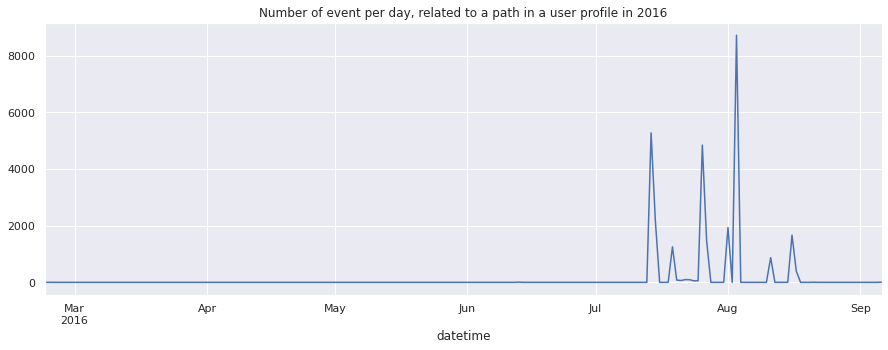

In [12]:
#f_year = df.index.year >= 2004
#f_year = (df.index.year >= 2014) & (df.index.year <=2016)
f_year = df.index.year == 2016
f_user = df['in_user_profile'] == True

s_nb_event_user = df[f_year & f_user].resample('D').size()
s_nb_event_user.plot(
    figsize=(15, 5), kind='line',
    title='Number of event per day, related to a path in a user profile in 2016'
)

After testing several period of time, we can deduce the incident arised in 2016, between July and August.

From this point, we work with a slice of the main dataframe, __df_refined__ that zooms on this period of time.

In [13]:
df_refined = df.loc['2016-07':'2016-08', :]

To confirm our time frame, we will use fair_tags: they are applied on a subset of events, well-known to hold evidence of malicious activity if any. 
Focusing on them at a first glance should reduce the noise around the anomalies.

We create a heatmap of the events per data source in this subset of events: a colored cell will indicate the source produced at least 1 event at the given timestamp. 
This will indicate if all source spreads evenly over __df_refined__ or if we can yet thin the time frame.

<AxesSubplot:title={'center':'Spread of the events per data source along the time frame'}, ylabel='source'>

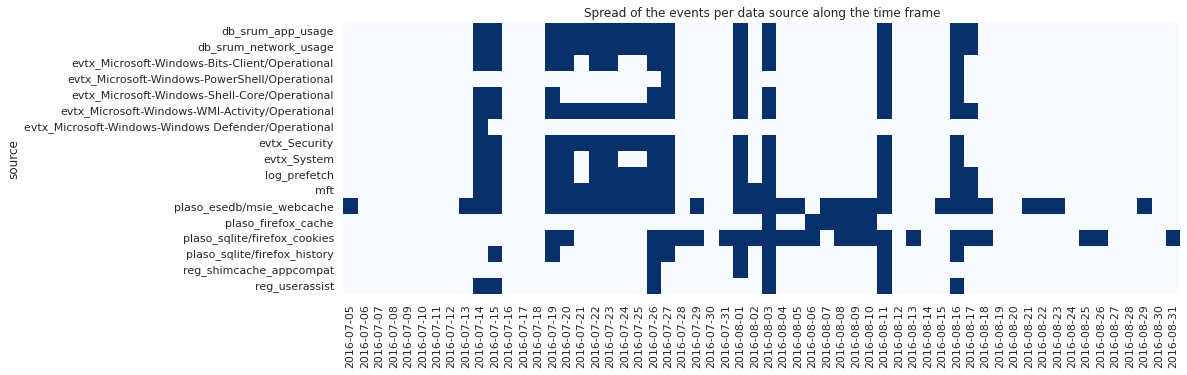

In [14]:
f_tags = df_refined['fair_tags'] != '-'
f_not_mft = df_refined['source'] != 'mft'
f_created = df_refined['file_created'] == True

#df_refined.loc[f_tags & (f_not_mft | f_created), 'source'].value_counts().to_frame()
df_sources = df_refined[f_tags & (f_not_mft | f_created)]\
    .groupby([pd.Grouper(freq='D'), 'source'])\
    .size()\
    .unstack()\
    .asfreq('D')\
    .fillna(0)\
    .gt(0)\
    .astype(int)\

df_sources.index = df_sources.index.date
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('Spread of the events per data source along the time frame')
sns.heatmap(df_sources.T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False)

The heatmap only draws a subset of events (files created and non empty fair_tags), we should keep in mind that  there might be interesting events between all these dates. However, all these selected sources agree on the majority of events occuring between July 14th and August 17th: we can consider it to be our hunting time frame. 

In [15]:
df_refined = df.loc['2016-07-14':'2016-08-17']

Let's see now, with the same visualization, how the fair_tags span in this time frame (MFT events excluded).

<AxesSubplot:ylabel='fair_tags'>

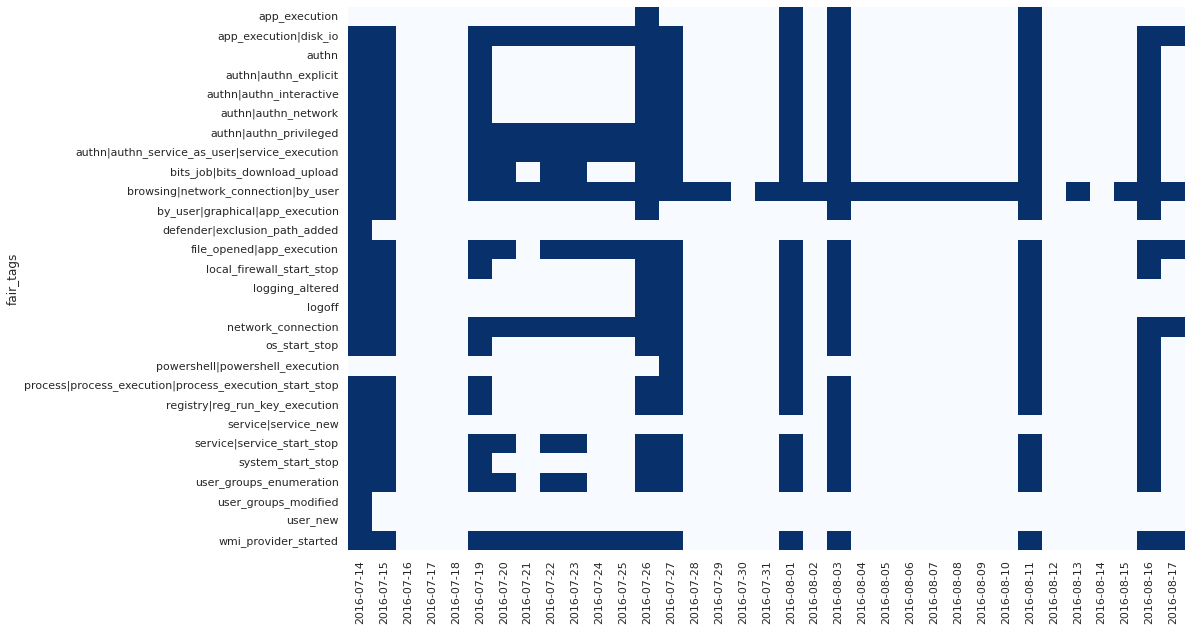

In [16]:
f_tags = df_refined['fair_tags'] != '-'
f_not_mft = df_refined['source'] != 'mft'

#df_refined.loc[f_tags & f_not_mft, 'fair_tags'].value_counts().to_frame()
df_tags = df_refined[f_tags & f_not_mft]\
    .groupby([pd.Grouper(freq='D'), 'fair_tags'])\
    .size()\
    .unstack()\
    .asfreq('D')\
    .fillna(0)\
    .gt(0)\
    .astype(int)\

df_tags.index = df_tags.index.date
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_tags.T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False)

The events tagged __user_new__ and __user_groups_modified__ are intriguing: they might be the doing of the threat actor creating some rogue users and escalating its privileges. 

Let's verify by collecting information from the raw events.

In [17]:
f_user = df_refined['fair_tags'].isin(['user_new', 'user_groups_modified'])

#df_refined.loc[f_user, 'raw'].to_frame()
df_refined.loc[f_user, 'evtx_info'].to_frame()

,evtx_info
datetime,
2016-07-14 14:13:26+00:00,Security|Microsoft-Windows-Security-Auditing|4732
2016-07-14 14:13:37+00:00,Security|Microsoft-Windows-Security-Auditing|4732
2016-07-14 14:13:37+00:00,Security|Microsoft-Windows-Security-Auditing|4732
2016-07-14 14:17:33+00:00,Security|Microsoft-Windows-Security-Auditing|4728
2016-07-14 14:17:33+00:00,Security|Microsoft-Windows-Security-Auditing|4720
2016-07-14 14:17:33+00:00,Security|Microsoft-Windows-Security-Auditing|4732
2016-07-14 14:17:33+00:00,Security|Microsoft-Windows-Security-Auditing|4732
2016-07-14 14:26:49+00:00,Security|Microsoft-Windows-Security-Auditing|4728
2016-07-14 14:26:49+00:00,Security|Microsoft-Windows-Security-Auditing|4720


The detailed info about these Windows events (from the complete events.ndjson file), tells that:
- 2 users were created (EID 4720):
    - defaultuser0, with SID S-1-5-21-1623514716-2111984414-578690546-1000
    - Peter, with SID S-1-5-21-1623514716-2111984414-578690546-1001
- They were both added to Users and Administrators groups (EID 4728, 4732): the threat actor does not need to look for privilege escalation on the host. 
- The remaining groups attribution (EID 4732) involves system accounts. 

The name 'defaultuser0' is a well-known temporary account used by Windows during its installation. 
Combined with the groups attributions for system accounts, we can safely deduce that July 14th was the setup of the workstation for this training case. 

As the creation of users and Windows setup generate lots of noise, we will slice our time frame to July 15th.

In [18]:
df_refined = df.loc['2016-07-15':'2016-08-17']

In [19]:
answers['privesc'].append('Peter, S-1-5-21-1623514716-2111984414-578690546-1001, is local admin')

## First Indicator(s) Hunting

From the first information collected (the case description), we know that the incident is a breach and that some data were leaked. 
We look for unusual files/folders (malware, threat actor tools to exfiltrate for instance) under user'profile.

For this purpose, we focus on files created in the user profile:
- collect files and folders (variable __s_paths__) 
- we split paths on the delimiter to group them on a given detph (function __extract_words__), 
- then count the occurences of each combination for a given depth.

In [20]:
f_mft_created = df_refined['file_created'] == True
f_user = df_refined['in_user_profile'] == True
s_paths = df_refined.loc[f_mft_created & f_user, 'raw']
s_paths.to_frame().head()

,raw
datetime,
2016-07-15 16:12:03+00:00,C:/Users/Peter/AppData/Local/Microsoft/OneDrive/setup/logs/Update_2016-07-15_181203_db8-dbc.log ($FILE_NAME)
2016-07-15 16:12:05+00:00,C:/Users/Peter/AppData/Local/Microsoft/Windows/INetCache/IE/YRCF31QU/update100[1].xml ($FILE_NAME)
2016-07-15 16:12:14+00:00,C:/Users/Peter/AppData/Local/Microsoft/Windows/Notifications/wpnidm/bf896e12.jpg ($FILE_NAME)
2016-07-15 16:12:27+00:00,C:/Users/Peter/AppData/Local/Microsoft/Windows/Notifications/wpnidm/d5a1e752.jpg ($FILE_NAME)
2016-07-15 16:12:29+00:00,C:/Users/Peter/AppData/Local/Microsoft/Windows/Caches/{AFBF9F1A-8EE8-4C77-AF34-C647E37CA0D9}.1.ver0x0000000000000003.db ($FILE_NAME)


In [21]:
def extract_words(s_paths, depth):
    words = []
    for path in s_paths:
        units = path.lower().split('/')
        words.extend(['/'.join(units[i:i+depth]) for i in range(0, len(units))])

    return words

Let's start with depth=3 to figure out how many users were active in this time frame.

In [22]:
words = extract_words(s_paths, 3)
s_words = pd.Series(words, name='nb_paths').value_counts().sort_values()
s_words[s_words.index.str.startswith('c:')].to_frame()

,nb_paths
c:/users/default,1
c:/users/public,4
c:/users/peter,9748


The only real user involved is 'peter'. 

Let's now move forward in the path, to highlight the folders the most subject to file creation in our time frame.

In [23]:
words = extract_words(s_paths, 3)
s_words = pd.Series(words, name='nb_paths').value_counts().sort_values()
s_words[s_words.index.str.startswith('users/peter/')].to_frame()

,nb_paths
users/peter/.gimp-2.8 ($file_name),1
users/peter/tracing ($file_name),1
users/peter/pictures,1
users/peter/downloads,2
users/peter/desktop,5
users/peter/tracing,7
users/peter/.gimp-2.8,35
users/peter/appdata,9696


Several files were created in interesting locations:
- Peter/Desktop, and Peter/Downloads: they could point to malicious documents the user would have been tricked to download and open, we will check them.
- Peter/Tracing/: the name 'tracing' is quite unusual, we will verify its purpose
- Peter/AppData, a lot, we will have to apply more filtering to exclude the noise inherent to application executions 

We start with the Downloads and Desktop folders.

In [24]:
f_documents = df_refined['raw'].str.lower().str.contains(r'peter/downloads|peter/desktop')
f_mft_created = df_refined['file_created'] == True

df_refined.loc[f_documents & f_mft_created, ['raw', 'file_size_mb', 'timestamp_desc']]

,raw,file_size_mb,timestamp_desc
datetime,,,
2016-07-15 18:00:24+00:00,C:/Users/Peter/Desktop/GIMP 2 - Shortcut.lnk ($FILE_NAME),0.000108,macb
2016-07-26 08:28:24+00:00,C:/Users/Peter/Downloads/inkscape-0.91.msi ($FILE_NAME),0.000100,.a.b
2016-07-26 08:36:23+00:00,C:/Users/Peter/Desktop/Documents ($FILE_NAME),0.000084,macb
2016-07-26 08:36:40+00:00,C:/Users/Peter/Desktop/Documents/Numbers.txt ($FILE_NAME),0.000088,macb
2016-07-26 08:38:07+00:00,C:/Users/Peter/Desktop/Documents/Customers.txt ($FILE_NAME),0.000092,macb
2016-08-03 11:55:19+00:00,C:/Users/Peter/Downloads/Thunderbird Setup 45.2.0.exe ($FILE_NAME),0.000122,.a.b
2016-08-11 13:54:26+00:00,C:/Users/Peter/Desktop/Documents/company_documents.zip ($FILE_NAME),0.000108,macb


In Downloads/, Thunderbird and Inkscape are the legitimate ones.

In Desktop/:
- the folder 'Documents' was created on July 26th at 8h36 UTC
- then a file Numbers.txt, 37 bytes, was added
- as well as another file, Customers.txt, 437 bytes
- lastly, an archive company_documents.zip, 41.8 MB, created on August 11th at 13h54 UTC

The text files are not malicious but contains some company data, and the archive, encrypted with a weak password, contains kitten photos.

As the case indicates that some company data were leaked, these files are good candidates. 
We extract all events related to them (files might have been copied elsewhere by the threat actor).

In [25]:
company_data = ['numbers.txt', 'customers.txt', 'company_documents.zip']

In [26]:
f_data = df['raw'].str.lower().str.contains('|'.join(company_data))
f_created = df['file_created'] == True
f_not_mft = df['source'] != 'mft'

s_keywords = df.loc[f_data, 'raw']\
    .str.lower().str.extract('('+ '|'.join(company_data) + ')', expand=False)

df[f_data]\
    .groupby([s_keywords, 'source']).size()\
    .unstack()\
    .fillna(0)\
    .astype(int)\
    .style.highlight_between(left=0, inclusive='right', color='skyblue')

source,mft,plaso_esedb/msie_webcache,plaso_lnk/shell_items,plaso_olecf/olecf_automatic_destinations/lnk/shell_items,plaso_winreg/bagmru/shell_items
raw,,,,,
company_documents.zip,8,8,6,3,3
customers.txt,3,12,3,6,0
numbers.txt,3,12,3,6,0


According to the table, there are:
- 14 MFT event (file creation/access/modification)
- 30 shell items (file accessed, file opened with a graphical application)
- 32 MSIE webcache events (Windows specificity, when a file is opened from the explorer, it "sometimes" ends in Internet Explorer 10/11 cache).

Reusing the heatmap, we display their distribution over the time. 
This time, we group events not only by the data source, but also by the type of timestamp: 76 events are a lot for only 3 files, we want an easy visualization to understand what happened with them.

<AxesSubplot:ylabel='source-timestamp_desc'>

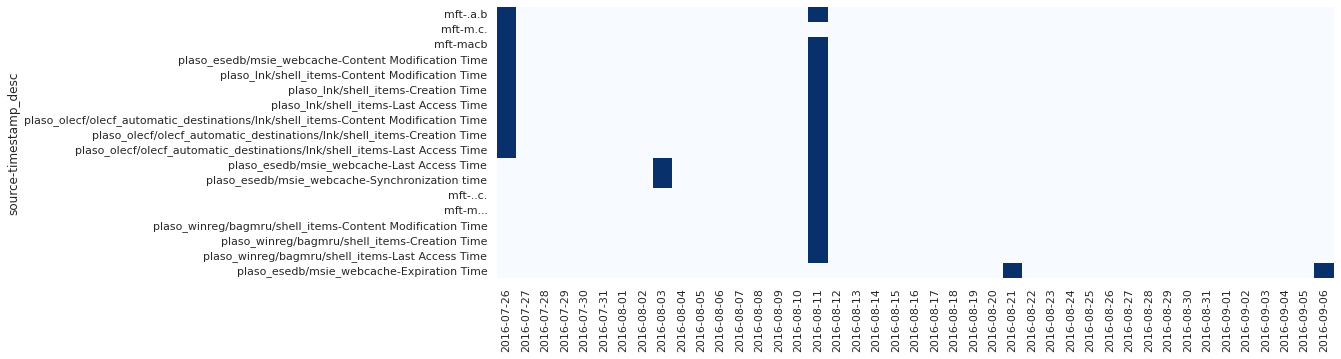

In [27]:
f_data = df['raw'].str.lower().str.contains('|'.join(company_data))

df_sources = df[f_data]\
    .groupby([pd.Grouper(freq='D'), 'source', 'timestamp_desc'])\
    .size()\
    .unstack(['source', 'timestamp_desc'])\
    .asfreq('D')\
    .fillna(0)\
    .gt(0)\
    .astype(int)\

df_sources.index = df_sources.index.date
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df_sources.T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False)

None of the MSIE webcache events brings anything compared to the MFT events: they relate to cache access, synchronization and expiration, which are background activity of a browser and not deliberate by the user or the threat actor. 

Regarding shell items, the same applies: they occur at the same time than the MFT events, and bring nothing except a evidence of access.  

We now check the location of these files: were there any copy out of Peter/Desktop/Documents/ ?

In [28]:
f_data = df['raw'].str.lower().str.contains('|'.join(company_data))
f_created = df['file_created'] == True

df.loc[f_data & f_created, ['raw']]

,raw
datetime,
2016-07-26 08:36:40+00:00,C:/Users/Peter/Desktop/Documents/Numbers.txt ($FILE_NAME)
2016-07-26 08:38:07+00:00,C:/Users/Peter/Desktop/Documents/Customers.txt ($FILE_NAME)
2016-08-11 13:54:26+00:00,C:/Users/Peter/Desktop/Documents/company_documents.zip ($FILE_NAME)
2016-08-11 13:54:30+00:00,C:/Users/Peter/AppData/Local/Temp/Temp1_company_documents.zip ($FILE_NAME)
2016-08-11 13:54:30+00:00,C:/Users/Peter/AppData/Local/Temp/Temp1_company_documents.zip/company_documents ($FILE_NAME)


There is a residue of the archive in the temp folder of the user Peter. 
As the timestamp matches the creation of the archive, this is just a standard Windows residue. 
These company data were not copied elsewhere on the disk.

Lastly, if we check occurences of filename in the files loaded for prefetchs (these info are only in the complete events.ndjson), we learn that the files were edited with notepad.exe.

In [29]:
answers['data'].extend([
    'company data created on July 26th, archive on August 11th',
    'company data created in Peter/Desktop/Documents/',
    'company data: {}'.format(', '.join(company_data)),
    'graphical access to company data (shell_items, msie_webcache)',
    'files edited with notepad (prefetchs)',
])

We have a last intriguing folder at the root of Peter's profile: 'tracing'.

We list the raw events related to this folder.

In [30]:
f_documents = df_refined['raw'].str.lower().str.contains('peter/tracing')
f_mft_created = df_refined['file_created'] == True

df_refined.loc[f_documents & f_mft_created, ['raw', 'file_size_mb']]

,raw,file_size_mb
datetime,,
2016-07-15 17:57:49+00:00,C:/Users/Peter/Tracing/WPPMedia/Skype_MediaStack-6.0.8962.185-releases_CL2016_R12-x86fre-U.etl ($FILE_NAME),0.000190
2016-07-15 17:57:49+00:00,C:/Users/Peter/Tracing/WPPMedia/Skype_MediaStack-6.0.8962.185-releases_CL2016_R12-x86fre-U.etl.bak ($FILE_NAME),0.000198
2016-07-15 17:57:49+00:00,C:/Users/Peter/Tracing/WPPMedia/Skype_MediaStackETW-6.0.8962.185-releases_CL2016_R12-x86fre-U.etl ($FILE_NAME),0.000196
2016-07-15 17:57:49+00:00,C:/Users/Peter/Tracing/WPPMedia/Skype_MediaStackETW-6.0.8962.185-releases_CL2016_R12-x86fre-U.etl.bak ($FILE_NAME),0.000204
2016-07-15 17:57:49+00:00,C:/Users/Peter/Tracing ($FILE_NAME),0.000080
2016-07-15 17:57:49+00:00,C:/Users/Peter/Tracing/WPPMedia ($FILE_NAME),0.000082
2016-08-16 12:57:48+00:00,C:/Users/Peter/Tracing/WPPMedia/Skype_MediaStack-6.0.8964.174-releases_CL2016_R14-x86fre-U.etl ($FILE_NAME),0.000190
2016-08-16 12:57:48+00:00,C:/Users/Peter/Tracing/WPPMedia/Skype_MediaStackETW-6.0.8964.174-releases_CL2016_R14-x86fre-U.etl ($FILE_NAME),0.000196


The literature tells us that this folder and etl files are generated for troubleshooting purposes, here for the application Skype. 
We can discard them.

We now have to analyze the AppData folder: it holds most of the files creation in our time frame (9696). 
This is not surprising by itself, as Windows maintains application settings, web history and many other application data in it.  
In the meantime, it is a first preferred choice by threat actors for the same reasons: this folder is writable by the user, noisy by nature, hence they can stay under the radar.  
As usual on Windows, the AppData folder is divided in 3 subfolders: LocalLow for sensitive application data, Local for application data that should not be synchronized on other devices, and Roaming for application data that will be synchronized (eg. the user logs in on another computer in the domain). 

We start by measuring and visualizing the file creation along the time frame.

In [31]:
words = extract_words(s_paths, 3)
s_words = pd.Series(words, name='nb_paths').value_counts().sort_values()
s_words[s_words.index.str.startswith('peter/appdata')].to_frame()

,nb_paths
peter/appdata/locallow,58
peter/appdata/roaming,1778
peter/appdata/local,7860


As usual on a Windows system, Local and Roaming are noisy folders. 
To not hunt blindly, we look for a first indicator in Local folder containing more than 10 files creation. 

In [32]:
words = extract_words(s_paths, 4)
s_words = pd.Series(words, name='nb_paths').value_counts().sort_values()
s_words[s_words.index.str.startswith('peter/appdata/local/') & (s_words > 10)].to_frame()

,nb_paths
peter/appdata/local/thunderbird,42
peter/appdata/local/temp,199
peter/appdata/local/packages,789
peter/appdata/local/microsoft,816
peter/appdata/local/mozilla,5983


The creation in Local/Temp for temporary files are pretty high (199) for the time frame, but it can be the due to some legitimate application behavior. 
Since it's also common to see attack residues here, we visualize the extension created along the time frame. 

<AxesSubplot:ylabel='raw'>

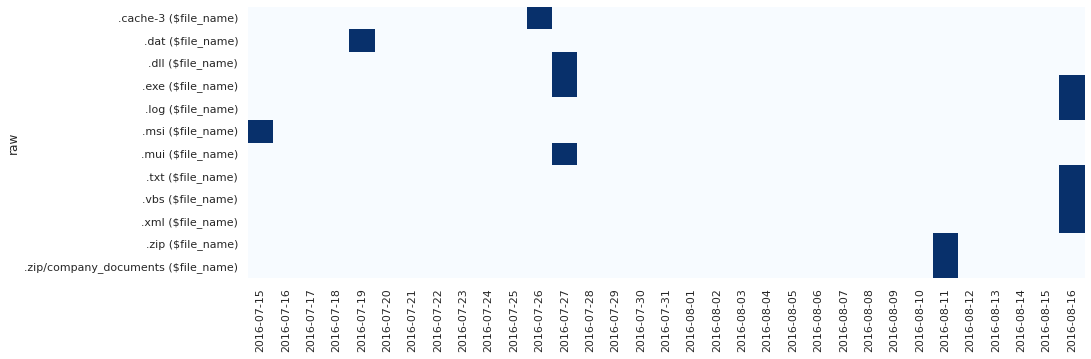

In [33]:
f_path = df_refined['raw'].str.lower().str.contains('peter/appdata/local/temp/')
f_created = df_refined['file_created'] == True

s_extension = df_refined.loc[f_path & f_created, 'raw']\
    .str.lower().str.extract('(\.[^.]*$)', expand=False)

df_temp = df_refined[f_path & f_created]\
    .groupby([pd.Grouper(freq='D'), s_extension])\
    .size()\
    .unstack()\
    .asfreq('D')\
    .fillna(0)\
    .gt(0)\
    .astype(int)\

df_temp.index = df_temp.index.date
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df_temp.T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False)

There are 3 extensions frequently used by threat actors: exe, dll (also executable), and vbs (scripting language). 

The DLLs are all legitimate (verified on the disk, signed by Microsoft, tighted to DismHost.exe), so we will focus on the EXE and VBS.

In [34]:
f_exe_vbs = df_refined['raw'].str.lower().str.contains(r'\.exe|\.vbs')
f_temp = df_refined['raw'].str.lower().str.contains('peter/appdata/local/temp/')
f_created = df_refined['file_created'] == True

df_refined.loc[f_temp & f_exe_vbs & f_created, ['raw', 'file_size_mb']]

,raw,file_size_mb
datetime,,
2016-07-27 13:11:56+00:00,C:/Users/Peter/AppData/Local/Temp/142B39F4-F367-4AD0-9D9D-C199CA55D6A7/DismHost.exe ($FILE_NAME),0.000090
2016-08-16 13:02:54+00:00,C:/Users/Peter/AppData/Local/Temp/exp.vbs ($FILE_NAME),0.000080
2016-08-16 13:02:57+00:00,C:/Users/Peter/AppData/Local/Temp/svchost.exe ($FILE_NAME),0.000088
2016-08-16 13:10:03+00:00,C:/Users/Peter/AppData/Local/Temp/54948tp.exe ($FILE_NAME),0.000088


As said above, we discard DismHost.exe. 
Only 3 files remains, all created on August 16th:
- exp.vbs is related to svchost.exe:
    - it downloads http[:]//blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe
    - save it as svchost.exe
    - execute it
- svchost.exe is a well-known binary name, but clearly not at this location, and oftenly abused by threat actor for the same reason. A quick check with online Threat Intelligence services points to Xtreme RAT (md5:7e9f416689d0a361252b38b6fe132f39)
- 54948tp.exe is PE32, and online Threat Intelligence services associate it with some Mimikatz signatures and report DNS requests to blog.mysportclub.ex (md5:f55f3e0359785e3c4511a7a2222ea6f8)

We have our first malicious indicators: before pivoting from them, we verify their occurencies in the dataframe and save the relevant events for the report.

In [35]:
answers['post_compromise'].extend([
    'svchost.exe = Xtreme RAT, md5 7e9f416689d0a361252b38b6fe132f39',
    'exp.vbs downloads Xtreme RAT (svchost.exe) and executes it',
    'exp.vbs downloads from http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe',
    '54948tp.exe matches Mimikatz signatures, md5 f55f3e0359785e3c4511a7a2222ea6f8',
    '54948tp.exe performs DNS requests to blog.mysportclub.ex'
])

In [36]:
new_indicators = [
    '/temp/svchost.exe', 'temp\\\\svchost.exe', 'temp\\\\\\\\svchost.exe', 
    'exp.vbs', '54948tp.exe', 'mysportclub.ex'
]

<AxesSubplot:ylabel='source'>

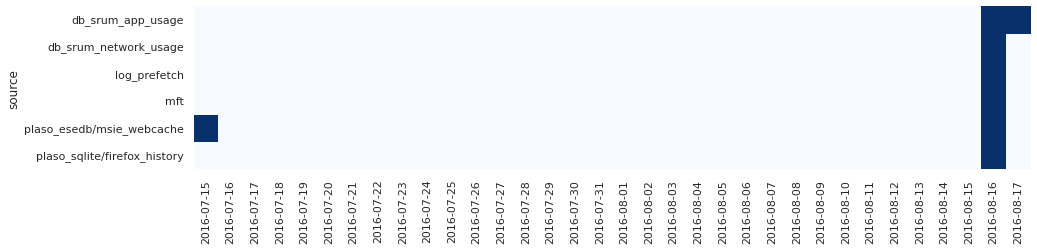

In [37]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_created = df['file_created'] == True
f_not_mft = df['source'] != 'mft'

#df.loc[f_indicators & (f_not_mft | f_created), 'source'].value_counts().to_frame()
df_indicators = df[f_indicators & (f_not_mft | f_created)]\
    .groupby([pd.Grouper(freq='D'), 'source'])\
    .size()\
    .unstack()\
    .asfreq('D')\
    .fillna(0)\
    .gt(0)\
    .astype(int)\

df_indicators.index = df_indicators.index.date
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(df_indicators.T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False)

The event from MSIE webcache on July 15th is surprising given that exp.vbs is created on August 16th. 
We check it separately, to determine if it is worth keeping.

In [38]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_source = df['source'].str.lower().str.contains('msie_webcache')

df.loc[f_indicators & f_source, ['timestamp_desc', 'raw']]

,timestamp_desc,raw
datetime,,
2016-07-15 14:08:11+00:00,Content Modification Time,"URL: http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe Access count: 1 Sync count: 1 Filename: 3568226350[1].exe Cached file size: 61440 Response headers: [HTTP/1.1 200 OK; ETag: W/""f000-53a1bf9153d40""; Content-Length: 61440; Keep-Alive: timeout=5, max=100; Content-Type: application/x-msdos-program] Entry identifier: 150 Container identifier: 1 Cache identifier: 0"
2016-08-16 13:02:56+00:00,Creation Time,"URL: http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe Access count: 1 Sync count: 1 Filename: 3568226350[1].exe Cached file size: 61440 Response headers: [HTTP/1.1 200 OK; ETag: W/""f000-53a1bf9153d40""; Content-Length: 61440; Keep-Alive: timeout=5, max=100; Content-Type: application/x-msdos-program] Entry identifier: 150 Container identifier: 1 Cache identifier: 0"
2016-08-16 13:02:57+00:00,Last Access Time,"URL: http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe Access count: 1 Sync count: 1 Filename: 3568226350[1].exe Cached file size: 61440 Response headers: [HTTP/1.1 200 OK; ETag: W/""f000-53a1bf9153d40""; Content-Length: 61440; Keep-Alive: timeout=5, max=100; Content-Type: application/x-msdos-program] Entry identifier: 150 Container identifier: 1 Cache identifier: 0"
2016-08-16 13:02:57+00:00,Synchronization time,"URL: http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe Access count: 1 Sync count: 1 Filename: 3568226350[1].exe Cached file size: 61440 Response headers: [HTTP/1.1 200 OK; ETag: W/""f000-53a1bf9153d40""; Content-Length: 61440; Keep-Alive: timeout=5, max=100; Content-Type: application/x-msdos-program] Entry identifier: 150 Container identifier: 1 Cache identifier: 0"


So, the event on July 15th is probably an error during the extraction, or an incorrect date set in the cache database: the cache file cannot be modified before being created.
We can focus after July 15th.

Since artifacts (data source) have different meaning (file created, execution, connections, ...), we create a pivot table of indicators occurences per data source. 
This allows to set a precise description for the report.

In [39]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_created = df['file_created'] == True
f_not_mft = df['source'] != 'mft'
f_start = df.index >= '2016-07-16'

s_keywords = df.loc[f_start & f_indicators & (f_not_mft | f_created), 'raw']\
    .str.lower().str.extract('('+ '|'.join(new_indicators) + ')', expand=False)

df[f_start & f_indicators & (f_not_mft | f_created)]\
    .groupby([s_keywords, 'source']).size()\
    .unstack()\
    .fillna(0)\
    .astype(int)\
    .style.highlight_between(left=0, inclusive='right', color='skyblue')

source,db_srum_app_usage,db_srum_network_usage,log_prefetch,mft,plaso_esedb/msie_webcache,plaso_sqlite/firefox_history
raw,,,,,,
/temp/svchost.exe,0,0,0,1,0,0
54948tp.exe,1,1,1,2,0,0
exp.vbs,0,0,0,1,0,0
mysportclub.ex,0,0,0,0,3,1
temp\svchost.exe,22,1,2,0,0,0


The SRUM DB events are noisy but we should keep them: it monitors applications in execution and their network connections every hour. 
Hence, while other artifacts might proves start of execution, this one adds the evidence that the application is still running.

Let's now flag these events for the report, and add a description.

In [40]:
f_created = df['file_created'] == True
f_exec = df['source'].str.lower().str.contains('srum_app|prefetch')
f_browsing = df['source'].str.lower().str.contains('msie_webcache|firefox_history')
f_connections = df['source'].str.lower().str.contains('srum_network')
f_start = df.index >= '2016-08-15'

# save events related to svchost.exe
f_indicator = df['raw'].str.lower().str.contains('temp/svchost.exe|temp\\\\svchost.exe')
df.loc[f_start & f_indicator & (f_created | f_exec | f_connections), 'to_keep'] = True

df.loc[f_start & f_indicator & f_created, 'report_desc'] = 'Xtreme RAT created on disk, Peter/AppData/Local/Temp/svchost.exe'
df.loc[f_start & f_indicator & f_created, 'mitre_tactic'] = 'Resource Development'

df.loc[f_start & f_indicator & f_exec, 'report_desc'] = 'Xtreme RAT (svchost.exe) executed'
df.loc[f_start & f_indicator & f_exec, 'mitre_tactic'] = 'Persistence'

df.loc[f_start & f_indicator & f_connections, 'report_desc'] = 'Xtreme RAT (svchost.exe) network connection'
df.loc[f_start & f_indicator & f_connections, 'mitre_tactic'] = 'Command and Control'

# save events related to 54948tp.exe
f_indicator = df['raw'].str.lower().str.contains('54948tp.exe')
df.loc[f_start & f_indicator & (f_created | f_exec | f_connections), 'to_keep'] = True

df.loc[f_start & f_indicator & f_created, 'report_desc'] = 'Peter/Local/Temp/54948tp.exe created on disk'
df.loc[f_start & f_indicator & f_created, 'mitre_tactic'] = 'Resource Development'

df.loc[f_start & f_indicator & f_exec, 'report_desc'] = '54948tp executed'
df.loc[f_start & f_indicator & f_exec, 'mitre_tactic'] = 'Credential Access'

df.loc[f_start & f_indicator & f_connections, 'report_desc'] = '54948tp.exe network connection'
df.loc[f_start & f_indicator & f_connections, 'mitre_tactic'] = 'Command and Control'

# save events related to exp.vbs
f_indicator = df['raw'].str.lower().str.contains('exp.vbs')
df.loc[f_start & f_indicator & f_created, 'to_keep'] = True
df.loc[f_start & f_indicator & f_created, 'report_desc'] = 'Peter/Local/Temp/exp.vbs created on disk'
df.loc[f_start & f_indicator & f_created, 'mitre_tactic'] = 'Resource Development'

#save events related to mysportclub.ex
f_indicator = df['raw'].str.lower().str.contains('mysportclub.ex')
df.loc[f_start & f_indicator & f_browsing, 'to_keep'] = True
df.loc[f_start & f_indicator & f_browsing, 'report_desc'] = 'Browsing on mysportclub.ex'
df.loc[f_start & f_indicator & f_browsing, 'mitre_tactic'] = 'Initial Access'

In [41]:
answers['persistence'].append('XTreme RAT')
answers['vector'].append('malicious download from blog.mysportclub.ex')
answers['start'].append('2016-08-16 13:02:56+00:00 (downloads Xtreme RAT from blog.mysportclub.ex)')
answers['c2'].extend([
    '54948tp.exe executed, connection to blog.mysportclub.ex',
    'Xtreme RAT executed'
])

In [42]:
indicators += new_indicators

## Taking a Step Back
We identified few indicators, and extracted all relevant events about them. 
To not get drifted, we review our timeline and notes to decide the next steps.

In [43]:
display_answers(answers)

,category,description
0,start,2016-08-16 13:02:56+00:00 (downloads Xtreme RAT from blog.mysportclub.ex)
1,vector,malicious download from blog.mysportclub.ex
2,privesc,"Peter, S-1-5-21-1623514716-2111984414-578690546-1001, is local admin"
3,persistence,XTreme RAT
4,post_compromise,"svchost.exe = Xtreme RAT, md5 7e9f416689d0a361252b38b6fe132f39"
5,post_compromise,exp.vbs downloads Xtreme RAT (svchost.exe) and executes it
6,post_compromise,exp.vbs downloads from http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe
7,post_compromise,"54948tp.exe matches Mimikatz signatures, md5 f55f3e0359785e3c4511a7a2222ea6f8"
8,post_compromise,54948tp.exe performs DNS requests to blog.mysportclub.ex
9,c2,"54948tp.exe executed, connection to blog.mysportclub.ex"


We can also display the timeline as a table with the raw events, but it will be less and less intellegible as it's growing. 
The timeline currently contains 36 events.

In [44]:
f_report = df['to_keep'] == True
print(f_report.sum())
df.loc[f_report, ['source', 'report_desc', 'raw']]

36


,source,report_desc,raw
datetime,,,
2016-08-16 13:02:52+00:00,plaso_sqlite/firefox_history,Browsing on mysportclub.ex,http://blog.mysportclub.ex/wp-content/uploads/hk/task/opspy/1ff1a5eb5ffe455641a17704db7e0a55.html (Lottery 2016) [count: 1] Host: blog.mysportclub.ex visited from: (URL not typed directly) Transition: LINK
2016-08-16 13:02:54+00:00,mft,Peter/Local/Temp/exp.vbs created on disk,C:/Users/Peter/AppData/Local/Temp/exp.vbs ($FILE_NAME)
2016-08-16 13:02:56+00:00,plaso_esedb/msie_webcache,Browsing on mysportclub.ex,"URL: http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe Access count: 1 Sync count: 1 Filename: 3568226350[1].exe Cached file size: 61440 Response headers: [HTTP/1.1 200 OK; ETag: W/""f000-53a1bf9153d40""; Content-Length: 61440; Keep-Alive: timeout=5, max=100; Content-Type: application/x-msdos-program] Entry identifier: 150 Container identifier: 1 Cache identifier: 0"
2016-08-16 13:02:57+00:00,mft,"Xtreme RAT created on disk, Peter/AppData/Local/Temp/svchost.exe",C:/Users/Peter/AppData/Local/Temp/svchost.exe ($FILE_NAME)
2016-08-16 13:02:57+00:00,plaso_esedb/msie_webcache,Browsing on mysportclub.ex,"URL: http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe Access count: 1 Sync count: 1 Filename: 3568226350[1].exe Cached file size: 61440 Response headers: [HTTP/1.1 200 OK; ETag: W/""f000-53a1bf9153d40""; Content-Length: 61440; Keep-Alive: timeout=5, max=100; Content-Type: application/x-msdos-program] Entry identifier: 150 Container identifier: 1 Cache identifier: 0"
2016-08-16 13:02:57+00:00,plaso_esedb/msie_webcache,Browsing on mysportclub.ex,"URL: http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe Access count: 1 Sync count: 1 Filename: 3568226350[1].exe Cached file size: 61440 Response headers: [HTTP/1.1 200 OK; ETag: W/""f000-53a1bf9153d40""; Content-Length: 61440; Keep-Alive: timeout=5, max=100; Content-Type: application/x-msdos-program] Entry identifier: 150 Container identifier: 1 Cache identifier: 0"
2016-08-16 13:02:57+00:00,log_prefetch,Xtreme RAT (svchost.exe) executed,"Prefetch [SVCHOST.EXE] was executed - run count 1 path hints: \USERS\PETER\APPDATA\LOCAL\TEMP\SVCHOST.EXE hash: 0xEE2F1EFB volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]"
2016-08-16 13:09:32+00:00,log_prefetch,Xtreme RAT (svchost.exe) executed,"Prefetch [SVCHOST.EXE] was executed - run count 1 path hints: \USERS\PETER\APPDATA\LOCAL\TEMP\SVCHOST.EXE hash: 0xCE7EE04C volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]"
2016-08-16 13:10:03+00:00,mft,Peter/Local/Temp/54948tp.exe created on disk,C:/Users/Peter/AppData/Local/Temp/54948tp.exe ($FILE_NAME)


But we can also leverage our descriptions to visualize the timeline with a heatmap. 
 
To draw with a better granularity (2 minutes span), we reduce the number of SRUM application usage displayed as they are the only repeated event starting from August 16th 15h00.

<AxesSubplot:xlabel='datetime', ylabel='report_desc'>

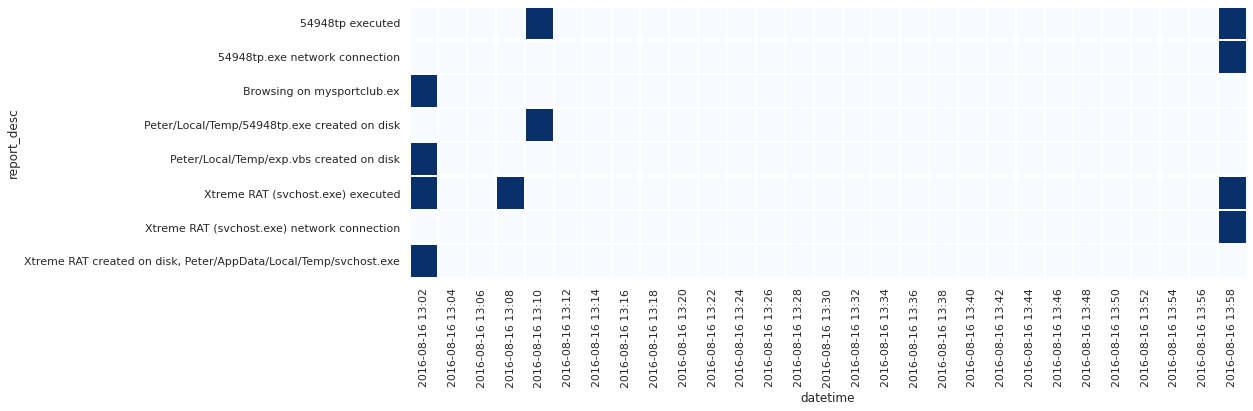

In [45]:
f_report = df['to_keep'] == True
f_start = df.index > '2016-08-12'
f_end = df.index < '2016-08-16 15:00'

df_timeline = df[f_report & f_start & f_end]\
    .groupby([pd.Grouper(freq='2T'), 'report_desc'])\
    .size()\
    .unstack()\
    .asfreq('2T')\
    .fillna(0)\
    .gt(0)\
    .astype(int)

df_timeline.index = df_timeline.index.to_period('T')
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df_timeline.T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, linewidth=0.1)

The earliest signs of attack are a browsing on mysportclub.ex, resulting in the creation of a malicious script (exp.vbs) then immediate installation and execution of Xtreme RAT. 
Once the remote access is established, 54948tp.exe get created and executed.
All of this occured on August 16th between 13h00 and 13h05 (the detailed table tells us it's 13h02).

We should now:
- check if the threat actor dropped other files on the disk on August 16th, which might exhibit further indicators
- refine the traces around 13h02 to underdstand the beginning of the attack and the vector of compromise

## Disk Timeline on August 16th
We check if the threat actor created other files in Peter/AppData (identified earlier) on the presumed day of the attack, which are not yet in our report. 

We achieve this by reusing the previous methodology:
- extract the file paths for these constraints
- split them on the path delimiter
- count the creations under a path for a given depth

### AppData/Local/

In [46]:
f_created = df_refined['file_created'] == True
f_user = df_refined['in_user_profile'] == True
f_not_found = df_refined['to_keep'] == False
f_period = (df_refined.index > '2016-08-16') & (df_refined.index < '2016-08-17')

s_paths = df_refined.loc[f_created & f_user & f_period & f_not_found, 'raw']

words = extract_words(s_paths, 2)
s_words = pd.Series(words, name='nb_paths').value_counts().sort_values()
s_words[s_words.index.str.startswith('appdata/')].to_frame()

,nb_paths
appdata/roaming,281
appdata/local,286


The well-known folder AppData/Roaming and AppData/Local might have more to reveal. 

We start with AppData/Local, excluding the noisy folder 'Packages'.

In [47]:
f_created = df_refined['file_created'] == True
f_user = df_refined['in_user_profile'] == True
f_not_found = df_refined['to_keep'] == False
f_packages = df_refined['raw'].str.lower().str.contains('appdata/local/packages')
f_period = (df_refined.index > '2016-08-16') & (df_refined.index < '2016-08-17')

s_paths = df_refined.loc[f_created & f_user & f_period & f_not_found & ~f_packages, 'raw']

words = extract_words(s_paths, 5)
s_words = pd.Series(words, name='nb_paths').value_counts().sort_values()
s_words[s_words.index.str.startswith('appdata/local')].to_frame()

,nb_paths
appdata/local/microsoft/onedrive/setup,1
appdata/local/microsoft/onedrive/logs,1
appdata/local/temp/mozilla-temp-files ($file_name),1
appdata/local/microsoft/windows/caches,1
appdata/local/temp/omm86dzv ($file_name),1
appdata/local/temp/systemprofile ($file_name),1
appdata/local/temp/systemprofile/sysinfo.txt ($file_name),1
appdata/local/putty.rnd ($file_name),1
appdata/local/temp/systemprofile/mimikatz.log ($file_name),1
appdata/local/temp/systemprofile/netscan ($file_name),1


The folder AppData/Local/Temp/SystemProfile is suspicious: 'mimikatz.log', 'netscan' does not sound like standard user activity. 



In [48]:
f_systemprofile = df_refined['raw'].str.lower().str.contains('peter/appdata/local/temp/systemprofile')
f_created = df_refined['file_created'] == True

df_refined[f_systemprofile & f_created][['raw', 'file_size_mb']]

,raw,file_size_mb
datetime,,
2016-08-16 13:14:47+00:00,C:/Users/Peter/AppData/Local/Temp/SystemProfile ($FILE_NAME),0.000092
2016-08-16 13:14:48+00:00,C:/Users/Peter/AppData/Local/Temp/SystemProfile/mimikatz.log ($FILE_NAME),0.000090
2016-08-16 13:14:50+00:00,C:/Users/Peter/AppData/Local/Temp/SystemProfile/bpd.log ($FILE_NAME),0.000080
2016-08-16 13:34:25+00:00,C:/Users/Peter/AppData/Local/Temp/SystemProfile/sysinfo.txt ($FILE_NAME),0.000088
2016-08-16 13:52:21+00:00,C:/Users/Peter/AppData/Local/Temp/SystemProfile/netscan ($FILE_NAME),0.000080
2016-08-16 13:59:29+00:00,C:/Users/Peter/AppData/Local/Temp/SystemProfile/netscan/192.168.5.1.xml ($FILE_NAME),0.000096
2016-08-16 13:59:34+00:00,C:/Users/Peter/AppData/Local/Temp/SystemProfile/netscan/192.168.5.10.xml ($FILE_NAME),0.000098
2016-08-16 13:59:36+00:00,C:/Users/Peter/AppData/Local/Temp/SystemProfile/netscan/192.168.5.15.xml ($FILE_NAME),0.000098


When we verify the files content on the disk mounted, we confirm these files are typical result of discovery:
- __mimikatz.log__: as Peter account is a member of Administrators group, several hashes could be grabbed from the memory. The hash of Peter password is leaked, the account should be considered as compromised.
- __bpd.log__ comes from the tool BrowserPasswordDump: the credentials of peterwilkins@consultant.com for the websites www.mail.com and www.imdb.com are compromised
- __sysinfo.txt__ contains many information about the account Peter (privileges, groups, network, routing, shares, firewall status, OS info, policies enforced). The IP address of the host at the time of attacker scan was 192.168.5.100
- __netscan__ folder contains Nmap results for 3 IPs, which compared to sysinfo.txt are respectively the default gateway,  a DNS server, and a yet unknown device in the same vlan (192.168.5.1/24). The XML files contains the command line executed, which points the path of Nmap to C:\\Users\\Peter\\AppData\\Roaming\\EpUpdate\\nmap\\nmap.exe

In [49]:
answers['post_compromise'].extend([
    'discovery results: mimikatz, browser password dump, nmap, system info',
    'subject IP: 192.168.5.100 (192.168.5.1/24)',
    'host scanned: 192.168.5.15',
    'DNS server: 192.168.5.10'
])
answers['data'].extend([
    'account peterwilkins@consultant.com on www.mail.com is compromised (bdp logs)',
    'account peterwilkins@consultant.com on www.imdb.com is compromised (bdp logs)',
    'peter local account is compromised (mimikatz log)',
])

We verify the occurences of these indicators to save the relevant ones for the report. We also keep in mind to pay attention to the folder EpUpdate when we will analyze the Roaming folder at the next step.

In [50]:
new_indicators = [
    'temp/systemprofile', 'mimikatz.log', 'bpd.log', 'sysinfo.txt', 'netscan',
    '192.168.5.1', '192.168.5.10', '192.168.5.15', '192.168.5.100',
]

In [51]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_not_mft = df['source'] != 'mft'
f_created = df['file_created'] == True

#df.loc[f_indicators & (f_not_mft | f_created), 'source'].value_counts().to_frame()
s_keywords = df.loc[f_indicators & (f_not_mft | f_created), 'raw']\
    .str.lower().str.extract('('+ '|'.join(new_indicators) + ')', expand=False)

df[f_indicators & (f_not_mft | f_created)]\
    .groupby([s_keywords, 'source']).size()\
    .unstack()\
    .fillna(0)\
    .astype(int)\
    .style.highlight_between(left=0, inclusive='right', color='skyblue')

source,mft
raw,
temp/systemprofile,8


None of the individual indicators appears elsewhere than under the SystemProfile folder. 
We save the events as the results of the threat actor discovery.

In [52]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_not_mft = df['source'] != 'mft'
f_created = df['file_created'] == True

df.loc[f_indicators & (f_not_mft  | f_created), 'to_keep'] = True
df.loc[f_indicators & (f_not_mft  | f_created), 'report_desc'] = 'Discovery results written, Peter/AppData/Local/Temp/SystemProfile'
df.loc[f_indicators & (f_not_mft  | f_created), 'mitre_tactic'] = 'Discovery'

In [53]:
indicators += new_indicators

### AppData/Roaming

We have a last folder to analyze for files creation on August 16th: Appdata/Roaming. 
We know about at least one unwanted subfolder: EpUpdate, which contains the nmap binary.

We use the same methodology, splitting paths on the delimiter and looking for anomalies for a given depth.

In [54]:
f_created = df_refined['file_created'] == True
f_user = df_refined['in_user_profile'] == True
f_period = (df_refined.index > '2016-08-16') & (df_refined.index < '2016-08-17')

s_paths = df_refined.loc[f_created & f_user & f_period, 'raw']

words = extract_words(s_paths, 4)
s_words = pd.Series(words, name='nb_paths').value_counts().sort_values()
s_words[s_words.index.str.startswith('appdata/roaming/epupdate')].to_frame()

,nb_paths
appdata/roaming/epupdate/thc ($file_name),1
appdata/roaming/epupdate/mmktz ($file_name),1
appdata/roaming/epupdate/nircmd ($file_name),1
appdata/roaming/epupdate/ssh ($file_name),1
appdata/roaming/epupdate/pwdump ($file_name),1
appdata/roaming/epupdate/passwords.txt ($file_name),1
appdata/roaming/epupdate/nmap ($file_name),1
appdata/roaming/epupdate/bpd,1
appdata/roaming/epupdate/bpd ($file_name),1
appdata/roaming/epupdate ($file_name),1


Checking the files on the disk, we clearly laid hands on the threat actor toolbox:
- __nircmd__ to perform host reconnaissance and potentially more
- __nmap__ to scan to network around, and a variant with the ability to capture traffic
- __thc__ (hydra), a network logon cracker (with lot of file creation because the git repository was cloned)
- __pwdump__ to dump hashes from the SAM hives (hash of local users passwords)
- __mmktz__ (mimikatz) to dump passwords/hashes from the memory
- __wdigest.reg__, a Windows registry for the well-known 'wdigest' setting which forces cleartext passwords in memory
- __passwords.txt__, a list of 500 weak passwords
- __bpd__, the executable for BrowserPasswordDump
- ssh/scp (__plink.exe__ and __pscp.exe__) to move laterally


It's time to figure out the relevant events to keep for the report.

In [55]:
answers['post_compromise'].extend([
    'toolbox discovery: nircmd, nmap, winpcap-nmap',
    'toolbox credentials: thc, pwdump7, mimikatz, wdigest reg key, weak pwd dictionnary, bpd',
    'toolbox lateral movement: plink, pscp',
])

In [56]:
f_indicators = df['raw'].str.lower().str.contains('epupdate')
f_created = df['file_created'] == True
f_thc_git = df['raw'].str.lower().str.contains('epupdate/thc/.git/')

df.loc[f_indicators & f_created & ~f_thc_git, 'source'].value_counts().to_frame()

,source
mft,58


The whole toolbox account for 58 files, this will be noisy for the report. 
We take a look at the event related to the binaries and other significant files.

In [57]:
new_indicators = [
    'browserpassworddump.exe', 'mimilove.exe', 'mimikatz.exe',
    'nircmd.exe', 'nircmdc.exe', 'pwdump7.exe', 'plink.exe', 'pscp.exe', 'wdigest.reg', 
    'nmap.exe', 'winpcap-nmap-4.13.exe', 'hydra.exe', 'pw-inspector.exe'
]

In [58]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_created = (df['file_created'] == True) & ~df['raw'].str.lower().str.contains('prefetch')
f_not_mft = df['source'] != 'mft'

s_keywords = df.loc[f_indicators & (f_not_mft | f_created), 'raw']\
    .str.lower().str.extract('('+ '|'.join(new_indicators) + ')', expand=False)

df[f_indicators & (f_not_mft | f_created)]\
    .groupby([s_keywords, 'source']).size()\
    .unstack()\
    .fillna(0)\
    .astype(int)\
    .style.highlight_between(left=0, inclusive='right', color='skyblue')

source,db_srum_app_usage,db_srum_network_usage,evtx_Security,log_prefetch,mft,reg_userassist
raw,,,,,,
browserpassworddump.exe,0,0,0,1,1,0
hydra.exe,1,1,4,7,1,0
mimikatz.exe,0,0,0,1,1,0
mimilove.exe,0,0,0,0,1,0
nircmd.exe,0,0,0,0,1,0
nircmdc.exe,0,0,0,0,1,0
nmap.exe,0,0,0,8,1,0
plink.exe,2,2,0,6,1,0
pscp.exe,1,1,0,3,1,0


Apart from the files creation (mft data source), no traces of execution are found for 5 tools: mimilove, nircmd and its command line variant nircmdc, pw-inspector, pwdump7.

Checking the detailed information in events.ndjson, the Windows Events relate to the EID 4798, which is the enumeration of user's local group membership, hence they reflect the execution of Hydra.

We also observe that, removing the creations of the prefetch files, all the events are relevant, we save 48 events.

In [59]:
answers['lateral_movement'].append('execution with network connections of plink, pscp and hydra')

In [60]:
f_created = (df['file_created'] == True) & ~df['raw'].str.lower().str.contains('prefetch')
f_exec = df['source'].str.lower().str.contains('srum_app|prefetch|user_assist|evtx_Security')
f_connections = df['source'].str.lower().str.contains('srum_network')

f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
credentials = ['browserpassworddump.exe', 'hydra.exe', 'mimikatz.exe']
discovery = ['nmap.exe', 'winpcap-nmap-4.13.exe']
lateral = ['plink.exe', 'pscp.exe']

# save toolbox creation
df.loc[f_indicators & f_created, 'to_keep'] = True
df.loc[f_indicators & f_created, 'report_desc'] = 'Toolbox creation in Peter/AppData/Roaming/EpUpdate'
df.loc[f_indicators & f_created, 'mitre_tactic'] = 'Resource Development'

# save executions
for indicator in credentials:
    f_indicator = df['raw'].str.lower().str.contains(indicator)
    df.loc[f_indicator & f_exec, 'to_keep'] = True
    df.loc[f_indicator & f_exec, 'report_desc'] = '{} executed'.format(indicator)
    df.loc[f_indicator & f_exec, 'mitre_tactic'] = 'Credential Access'
for indicator in discovery:
    f_indicator = df['raw'].str.lower().str.contains(indicator)
    df.loc[f_indicator & f_exec, 'to_keep'] = True
    df.loc[f_indicator & f_exec, 'report_desc'] = '{} executed'.format(indicator)
    df.loc[f_indicator & f_exec, 'mitre_tactic'] = 'Discovery'
for indicator in lateral:
    f_indicator = df['raw'].str.lower().str.contains(indicator)
    df.loc[f_indicator & f_exec, 'to_keep'] = True
    df.loc[f_indicator & f_exec, 'report_desc'] = '{} executed'.format(indicator)
    df.loc[f_indicator & f_exec, 'mitre_tactic'] = 'Lateral Movement'

# save network connections    
for indicator in new_indicators:
    f_indicator = df['raw'].str.lower().str.contains(indicator)
    df.loc[f_indicator & f_connections, 'to_keep'] = True
    df.loc[f_indicator & f_connections, 'report_desc'] = '{} network connections'.format(indicator)
    df.loc[f_indicator & f_connections, 'mitre_tactic'] = 'Lateral Movement'

f_report = df['to_keep'] == True
df.loc[f_indicators & f_report, 'to_keep'].sum()

48

In [61]:
indicators += new_indicators

We conclude our analysis of the Roaming folder with the creation on August 16th not related to EpUpdate.

In [62]:
f_created = df_refined['file_created'] == True
f_user = df_refined['in_user_profile'] == True
f_not_found = df_refined['to_keep'] == False
f_epupdate = df_refined['raw'].str.lower().str.contains('epupdate')
f_period = (df_refined.index > '2016-08-16') & (df_refined.index < '2016-08-17')

s_paths = df_refined.loc[f_created & f_user & f_period & f_not_found & ~f_epupdate, 'raw']

words = extract_words(s_paths, 4)
s_words = pd.Series(words, name='nb_paths').value_counts().sort_values()
s_words[s_words.index.str.startswith('appdata/roaming')].to_frame()

,nb_paths
appdata/roaming/microsoft/spelling ($file_name),1
appdata/roaming/hostdata/update.exe ($file_name),1
appdata/roaming/hostdata ($file_name),1
appdata/roaming/hostdata/rarreg.key ($file_name),1
appdata/roaming/hostdata/rar.exe ($file_name),1
appdata/roaming/skype/shared_dynco,2
appdata/roaming/skype/shared_httpfe,2
appdata/roaming/microsoft/windows,6
appdata/roaming/mozilla/firefox,10
appdata/roaming/skype/live#3apeterwilkins_2,23


The folder HostData contains 2 executables created on August 16th, it's worth checking.

In [63]:
f_created = df_refined['file_created'] == True
f_hostdata = df_refined['raw'].str.lower().str.contains('hostdata')

df_refined.loc[f_created & f_hostdata, ['raw']]

,raw
datetime,
2016-08-16 13:02:57+00:00,C:/Users/Peter/AppData/Roaming/HostData ($FILE_NAME)
2016-08-16 13:02:57+00:00,C:/Users/Peter/AppData/Roaming/HostData/update.exe ($FILE_NAME)
2016-08-16 13:48:12+00:00,C:/Users/Peter/AppData/Roaming/HostData/rar.exe ($FILE_NAME)
2016-08-16 13:48:12+00:00,C:/Users/Peter/AppData/Roaming/HostData/rarreg.key ($FILE_NAME)


Once again, checking on the disk:
- __update.exe__ is a copy of Xtreme RAT (same md5)
- __rar.exe__ seems to be the legitimate WinRAR (md5 b97727a338b9aaa980e0fc4baec1f92b)
- __rarreg.key__, probably linked to rar.exe, is a registry key containing the string xtremerat

There are new indicators, and as usual, we look for any events related to them, then save for the report.

In [64]:
answers['post_compromise'].extend([
    'rar.exe: WinRAR utility packed with UPX, md5 b97727a338b9aaa980e0fc4baec1f92b',
    'rarreg.key: contain string xtremerat',
])
answers['persistence'].append(
    'update.exe is also Xtreme RAT (same md5 as svchost.exe)',
)

In [65]:
new_indicators = [
    'hostdata/update.exe', 'hostdata\\\\update.exe', 'hostdata\\\\\\\\update.exe',
    'hostdata/rar.exe', 'hostdata\\\\rar.exe', 'hostdata\\\\\\\\rar.exe', 'rarreg.key',
]

In [66]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_created = df['file_created'] == True
f_not_mft = df['source'] != 'mft'

s_keywords = df.loc[f_indicators & (f_not_mft | f_created), 'raw']\
    .str.lower().str.extract('('+ '|'.join(new_indicators) + ')', expand=False)

df[f_indicators & (f_not_mft | f_created)]\
    .groupby([s_keywords, 'source']).size()\
    .unstack()\
    .fillna(0)\
    .astype(int)\
    .style.highlight_between(left=0, inclusive='right', color='skyblue')

source,db_srum_app_usage,db_srum_network_usage,evtx_Microsoft-Windows-Application-Experience/Program-Compatibility-Assistant,log_prefetch,mft,plaso_winreg/windows_run
raw,,,,,,
hostdata/rar.exe,0,0,0,0,1,0
hostdata/update.exe,0,0,0,0,1,0
hostdata\\update.exe,0,0,0,0,0,4
hostdata\update.exe,22,22,1,2,0,0
rarreg.key,0,0,0,0,1,0


In [67]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_not_srum = ~df['source'].str.lower().str.contains('db_srum')
f_not_mft = df['source'] != 'mft'
df.loc[f_indicators & f_not_srum & f_not_mft, ['source', 'raw']]

,source,raw
datetime,,
2016-08-16 13:02:57+00:00,plaso_winreg/windows_run,"[HKEY_CURRENT_USER\Software\Microsoft\Windows\CurrentVersion\Run] Entries: ['HKCU: C:\\Users\\Peter\\AppData\\Roaming\\HostData\\update.exe', 'OneDrive: ""C:\\Users\\Peter\\AppData\\Local\\Microsoft\\OneDrive\\OneDrive.exe"" /background', 'Skype: ""C:\\Program Files\\Skype\\Phone\\Skype.exe"" /minimized /regrun']"
2016-08-16 13:02:57+00:00,plaso_winreg/windows_run,[HKEY_CURRENT_USER\Software\Microsoft\Windows\CurrentVersion\RunOnce] Entries: ['Update: C:\\Users\\Peter\\AppData\\Roaming\\HostData\\update.exe']
2016-08-16 13:03:03+00:00,log_prefetch,"Prefetch [UPDATE.EXE] was executed - run count 2 path hints: \USERS\PETER\APPDATA\ROAMING\HOSTDATA\UPDATE.EXE hash: 0xF6A87B54 volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]"
2016-08-16 13:03:04+00:00,plaso_winreg/windows_run,[HKEY_LOCAL_MACHINE\Software\Microsoft\Windows\CurrentVersion\Run] Entries: ['HKLM: C:\\Users\\Peter\\AppData\\Roaming\\HostData\\update.exe']
2016-08-16 13:03:04+00:00,log_prefetch,"Prefetch [UPDATE.EXE] was executed - run count 2 path hints: \USERS\PETER\APPDATA\ROAMING\HOSTDATA\UPDATE.EXE hash: 0xF6A87B54 volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]"
2016-08-16 13:22:04+00:00,plaso_winreg/windows_run,[HKEY_LOCAL_MACHINE\Software\Microsoft\Windows\CurrentVersion\RunOnce] Entries: ['Update: C:\\Users\\Peter\\AppData\\Roaming\\HostData\\update.exe']
2016-08-16 13:56:29+00:00,evtx_Microsoft-Windows-Application-Experience/Program-Compatibility-Assistant,"<Event xmlns=""http://schemas.microsoft.com/win/2004/08/events/event"">\n <System>\n <Provider Name=""Microsoft-Windows-Program-Compatibility-Assistant"" Guid=""{4CB314DF-C11F-47D7-9C04-65FB0051561B}""/>\n <EventID>17</EventID>\n <Version>0</Version>\n <Level>4</Level>\n <Task>0</Task>\n <Opcode>0</Opcode>\n <Keywords>0x4000000000000000</Keywords>\n <TimeCreated SystemTime=""2016-08-16T13:56:29.109129300Z""/>\n <EventRecordID>1</EventRecordID>\n <Correlation/>\n <Ex..."


In [68]:
f_created = df['file_created'] == True
f_exec = df['source'].str.lower().str.contains('srum_app|prefetch|evtx_')
f_connections = df['source'].str.lower().str.contains('srum_network')
f_autorun = df['source'].str.lower().str.contains('windows_run')

# save events related to rar
f_indicators = df['raw'].str.lower().str.contains('hostdata/rar.exe|rarreg.key')
df.loc[f_indicators & f_created, 'to_keep'] = True
df.loc[f_indicators & f_created, 'report_desc'] = 'WinRAR created on disk, Peter/AppData/Roaming/HostData'
df.loc[f_indicators & f_created, 'mitre_tactic'] = 'Resource Development'

f_indicators = df['raw'].str.lower().str.contains('hostdata/update.exe')
df.loc[f_indicators & f_created, 'to_keep'] = True
df.loc[f_indicators & f_created, 'report_desc'] = 'Xtreme RAT created on disk, Peter/AppData/Roaming/HostData/update.exe'
df.loc[f_indicators & f_created, 'mitre_tactic'] = 'Resource Development'

# save executions
f_indicators = df['raw'].str.lower().str.contains('hostdata\\\\update.exe')
df.loc[f_indicators & f_exec, 'to_keep'] = True
df.loc[f_indicators & f_exec, 'report_desc'] = 'Xtreme RAT (update.exe) executed'
df.loc[f_indicators & f_exec, 'mitre_tactic'] = 'Persistence'

# save connections
f_indicators = df['raw'].str.lower().str.contains('hostdata\\\\update.exe')
df.loc[f_indicators & f_connections, 'to_keep'] = True
df.loc[f_indicators & f_connections, 'report_desc'] = 'Xtreme RAT (update.exe) network connections'
df.loc[f_indicators & f_connections, 'mitre_tactic'] = 'Command and Control'

# save persistence
f_indicators = df['raw'].str.lower().str.contains('hostdata\\\\\\\\update.exe')
df.loc[f_indicators & f_autorun, 'to_keep'] = True
df.loc[f_indicators & f_autorun, 'report_desc'] = 'Run/RunOnce keys created for Xtreme RAT (update.exe, HKCU, HKLM)'
df.loc[f_indicators & f_autorun, 'mitre_tactic'] = 'Persistence'

In [69]:
answers['persistence'].append('Run/RunOnce keys for Xtreme RAT at system start and user login (HKLM, HKCU)')

In [70]:
indicators += new_indicators

## Taking a Step Back, Again

Once again, before moving forward, let's understand how the kept events are distributed over the time, what story they tell, which gray areas remains. 

In [71]:
f_report = df['to_keep'] == True

nb_events = df.loc[f_report].index.size
nb_descriptions = df.loc[f_report, 'report_desc'].nunique()
nb_mitre_tactic = df.loc[f_report, 'mitre_tactic'].nunique()
print(nb_events, nb_descriptions, nb_mitre_tactic)

146 25 7


Our report currently accounts for 146 events, 25 distinct descriptions and 7 distinct MITRE tactics. 
The timeline as a table with our description and the raw event is no longer intelligible as a whole. 
We reuse our heatmap to visualize the events description along the time. 
The additional abstraction provided by MITRE tactics gives a simplified view of the chain of events. 

To display a 10 minutes granularity, we reduce the number of SRUM application usage displayed as they are the only repeated event starting from August 16th 16:00. 
To not get lost with the 25 descriptions, we also tune our heatmap to get a clear view per MITRE tactic.

As the figure grows, we can right click on it and open in a new tab to get it bigger.

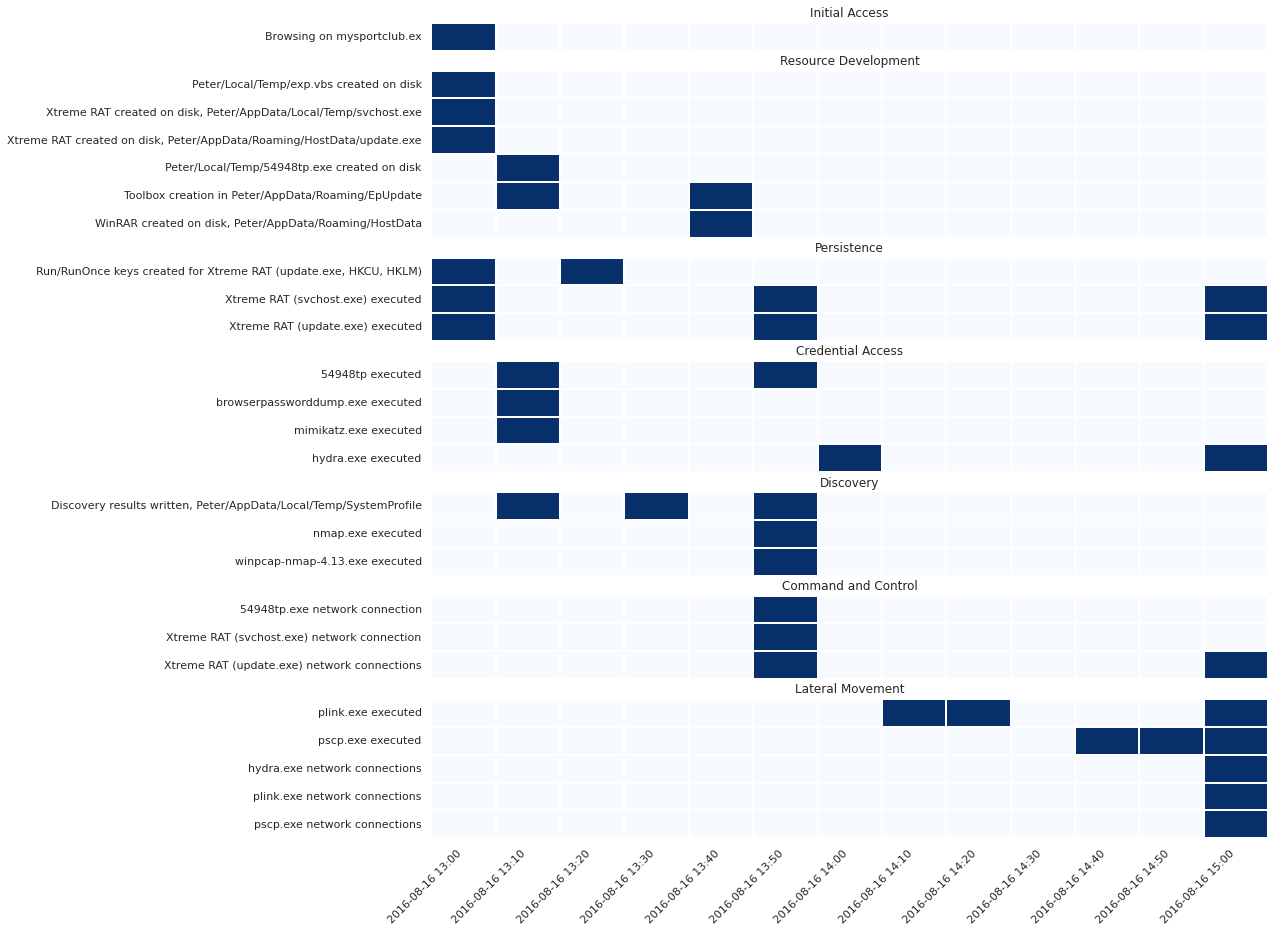

In [72]:
f_report = df['to_keep'] == True
f_end = df.index < '2016-08-16 16:00'

df_report = df[f_report & f_end]
tactics = df_report['mitre_tactic'].unique()
df_report = df_report\
    .groupby([pd.Grouper(freq='10T'), 'mitre_tactic', 'report_desc'])\
    .size()\
    .unstack(['mitre_tactic', 'report_desc'])\
    .asfreq('10T')\
    .fillna(0)\
    .gt(0)\
    .astype(int)
df_report.index = df_report.index.to_period('T')

total_events = df_report.T.index.size
ratios = []
for tactic in tactics:
    ratios.append(df_report[tactic].T.size/total_events)
fig, axs = plt.subplots(len(tactics), figsize=(15, 15), gridspec_kw={'height_ratios': ratios}, sharex=True)

for i in range(0, len(tactics)):
    tactic = tactics[i]
    axs[i].set_title(tactic)
    sns.heatmap(df_report[tactic].T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, linewidth=0.1, ax=axs[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=0)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')

We can also limit the labels to the MITRE tactics.

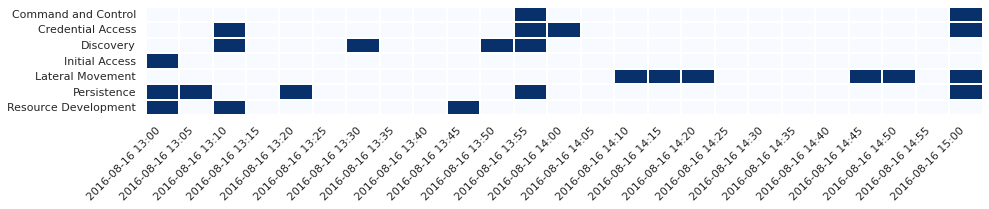

In [73]:
f_report = df['to_keep'] == True
f_end = df.index < '2016-08-16 16:00'

df_report = df[f_report & f_end]\
    .groupby([pd.Grouper(freq='5T'), 'mitre_tactic'])\
    .size()\
    .unstack()\
    .asfreq('5T')\
    .fillna(0)\
    .gt(0)\
    .astype(int)

df_report.index = df_report.index.to_period('T')
fig, ax = plt.subplots(figsize=(15, 2))
sns.heatmap(df_report.T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, linewidth=0.1)
ax.set_xlabel('')
ax.set_ylabel('')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


We can also focus on a particular type of events, here the network connections ones.

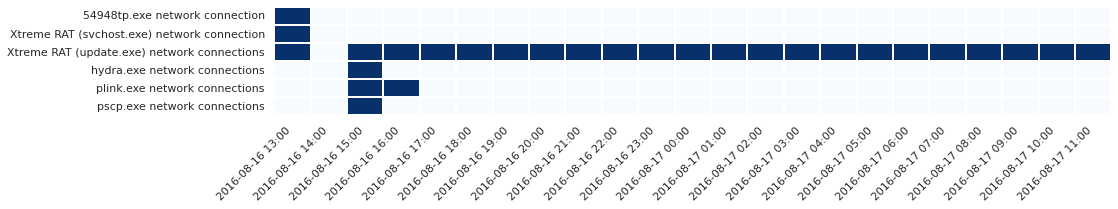

In [74]:
f_report = df['to_keep'] == True
f_connections = df['report_desc'].str.lower().str.contains('network')

df_report = df[f_report & f_connections]\
    .groupby([pd.Grouper(freq='H'), 'report_desc'])\
    .size()\
    .unstack()\
    .asfreq('H')\
    .fillna(0)\
    .gt(0)\
    .astype(int)

df_report.index = df_report.index.to_period('T')
fig, ax = plt.subplots(figsize=(15, 2))
sns.heatmap(df_report.T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, linewidth=0.1)
ax.set_xlabel('')
ax.set_ylabel('')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

We answered partially the questions stated at the begining. 
We define our next steps.

In [75]:
display_answers(answers)

,category,description
0,start,2016-08-16 13:02:56+00:00 (downloads Xtreme RAT from blog.mysportclub.ex)
1,vector,malicious download from blog.mysportclub.ex
2,privesc,"Peter, S-1-5-21-1623514716-2111984414-578690546-1001, is local admin"
3,persistence,XTreme RAT
4,persistence,update.exe is also Xtreme RAT (same md5 as svchost.exe)
5,persistence,"Run/RunOnce keys for Xtreme RAT at system start and user login (HKLM, HKCU)"
6,post_compromise,"svchost.exe = Xtreme RAT, md5 7e9f416689d0a361252b38b6fe132f39"
7,post_compromise,exp.vbs downloads Xtreme RAT (svchost.exe) and executes it
8,post_compromise,exp.vbs downloads from http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe
9,post_compromise,"54948tp.exe matches Mimikatz signatures, md5 f55f3e0359785e3c4511a7a2222ea6f8"


The next steps are:
- How come exp.vbs got written on the disk (link in email/file? plugged a removable media? software vulnerability exploitation?). We have to dig deeper around August 16th 13h02.
- We need to know more about Xtreme RAT C2: what is the threat actor IP address?
- We have evidence of lateral movement (execution of plink.exe at least). Where the threat actor pivoted?
- We know that few Peter's accounts are compromised. What about data exfiltration (what, how much)?

## The Beginning of the Attack

The earliest indicator is a malicious download from Firefox. 
So, we analyse the artifacts extracted from Firefox and IE (history, cache, cookies).

In [76]:
df_beginning = df.loc['2016-08-16 13:02', :]

In [77]:
f_browsing = df_beginning['source'].str.lower().str.contains('firefox|msie_webcache')
df_beginning.loc[f_browsing, 'source'].value_counts().to_frame()

,source
plaso_sqlite/firefox_cookies,38
plaso_sqlite/firefox_history,9
plaso_esedb/msie_webcache,4


We first review firefox cookies as they alone constitute 38 events. 
We extract the FQDN from the cookie to reduce the number of distinct values.

In [78]:
f_firefox_cookie = df_beginning['source'].str.lower().str.contains('firefox_cookie')

s_websites = df_beginning.loc[f_firefox_cookie, 'raw'].str.extract(r'^(http[\S]*)')
s_websites.value_counts().to_frame(name='nb_cookies')

,nb_cookies
0,
http://pubmatic.com/,15
http://reddit.com/,6
https://reddit.com/,4
http://scorecardresearch.com/,3
http://ads.pubmatic.com/,2
http://doubleclick.net/,2
http://adzerk.net/,1
http://engine.a.redditmedia.com/,1
http://redditmedia.com/,1


We end with 12 distinct websites in these cookies. 
None of them are known in Threat Intelligence to host malicious content. 

We therefore focus on firefox history and IE cache.

In [79]:
f_browsing = df_beginning['source'].str.lower().str.contains('firefox_history|msie_webcache')
f_websites = df_beginning['raw'].str.lower().str.contains('|'.join(s_websites[0].unique().tolist()))
f_report = df_beginning['to_keep'] == True

df_beginning.loc[(f_browsing & ~f_websites) | f_report, ['source', 'raw', 'report_desc', 'mitre_tactic']]

,source,raw,report_desc,mitre_tactic
datetime,,,,
2016-08-16 13:02:46+00:00,plaso_sqlite/firefox_history,http://blog.mycompany.ex/ [count: 1] Host: blog.mycompany.ex visited from: (URL not typed directly) Transition: TYPED,,
2016-08-16 13:02:46+00:00,plaso_sqlite/firefox_history,http://blog.mycompany.ex/ [count: 1] Host: blog.mycompany.ex visited from: (URL not typed directly) Transition: TYPED,,
2016-08-16 13:02:52+00:00,plaso_sqlite/firefox_history,http://blog.mysportclub.ex/wp-content/uploads/hk/task/opspy/1ff1a5eb5ffe455641a17704db7e0a55.html (Lottery 2016) [count: 1] Host: blog.mysportclub.ex visited from: (URL not typed directly) Transition: LINK,Browsing on mysportclub.ex,Initial Access
2016-08-16 13:02:54+00:00,mft,C:/Users/Peter/AppData/Local/Temp/exp.vbs ($FILE_NAME),Peter/Local/Temp/exp.vbs created on disk,Resource Development
2016-08-16 13:02:56+00:00,plaso_esedb/msie_webcache,"URL: http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe Access count: 1 Sync count: 1 Filename: 3568226350[1].exe Cached file size: 61440 Response headers: [HTTP/1.1 200 OK; ETag: W/""f000-53a1bf9153d40""; Content-Length: 61440; Keep-Alive: timeout=5, max=100; Content-Type: application/x-msdos-program] Entry identifier: 150 Container identifier: 1 Cache identifier: 0",Browsing on mysportclub.ex,Initial Access
2016-08-16 13:02:57+00:00,mft,C:/Users/Peter/AppData/Local/Temp/svchost.exe ($FILE_NAME),"Xtreme RAT created on disk, Peter/AppData/Local/Temp/svchost.exe",Resource Development
2016-08-16 13:02:57+00:00,mft,C:/Users/Peter/AppData/Roaming/HostData/update.exe ($FILE_NAME),"Xtreme RAT created on disk, Peter/AppData/Roaming/HostData/update.exe",Resource Development
2016-08-16 13:02:57+00:00,plaso_esedb/msie_webcache,"URL: http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe Access count: 1 Sync count: 1 Filename: 3568226350[1].exe Cached file size: 61440 Response headers: [HTTP/1.1 200 OK; ETag: W/""f000-53a1bf9153d40""; Content-Length: 61440; Keep-Alive: timeout=5, max=100; Content-Type: application/x-msdos-program] Entry identifier: 150 Container identifier: 1 Cache identifier: 0",Browsing on mysportclub.ex,Initial Access
2016-08-16 13:02:57+00:00,plaso_esedb/msie_webcache,"URL: http://blog.mysportclub.ex/wp-content/uploads/hk/5128f35c9b4be13788ba41bdb6d1fc1f/3568226350.exe Access count: 1 Sync count: 1 Filename: 3568226350[1].exe Cached file size: 61440 Response headers: [HTTP/1.1 200 OK; ETag: W/""f000-53a1bf9153d40""; Content-Length: 61440; Keep-Alive: timeout=5, max=100; Content-Type: application/x-msdos-program] Entry identifier: 150 Container identifier: 1 Cache identifier: 0",Browsing on mysportclub.ex,Initial Access


We got more context around the creation of exp.vbs.

In [80]:
answers['start'].extend([
    'the page 1ff1a5eb5ffe455641a17704db7e0a55.html on blog.mysportclub.ex led to the creation of exp.vbs',
    '1ff1a5eb5ffe455641a17704db7e0a55.html was visited by following a link',
    'before this visit: the user visited blog.mycompany.ex by typing it',
    'after the download of Xtreme RAT, visited on an unusual port: http://36.98.102.89:12345/1234567890.functions'
])

Like every browser, Firefox caches visited pages. 
However, we don't have a data source extracting them. 
We collect them by checking the files created in the firefox cache folders, and we check their content on the disk to only keep the ones pertaining to the case.

We start with the cache created between the visit on blog.mycompany.ex and the first visit on blog.mysportclub.ex. 
We save the file names in __case_1/firefox_mycompany.txt__.

In [81]:
date_first_mycompany = df_beginning['raw'].str.lower().str.contains('blog.mycompany.ex').idxmax()
date_first_mysportclub = df_beginning['raw'].str.lower().str.contains('1ff1a5eb5ffe455641a17704db7e0a55.html').idxmax()
df_refined = df.loc[date_first_mycompany:date_first_mysportclub]

f_mft = df_refined['source'].str.lower() == 'mft'
f_cache = df_refined['raw'].str.lower().str.contains('peter/appdata/local/mozilla/firefox/.*/cache2/entries')
f_website = df_refined['raw'].str.lower().str.contains('mycompany.ex|mysportclub.ex')
f_created = df_refined['file_created'] == True

df_refined.loc[(f_mft & f_cache & f_created), ['raw']].to_csv('case_1/firefox_cache_mycompany.txt', index=False)
df_refined.loc[(f_mft & f_cache & f_created) | f_website, ['raw']].head()


,raw
datetime,
2016-08-16 13:02:46+00:00,http://blog.mycompany.ex/ [count: 1] Host: blog.mycompany.ex visited from: (URL not typed directly) Transition: TYPED
2016-08-16 13:02:46+00:00,http://blog.mycompany.ex/ [count: 1] Host: blog.mycompany.ex visited from: (URL not typed directly) Transition: TYPED
2016-08-16 13:02:47+00:00,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/1E59A17A31E5E9AC15D0715294784A83ACA233C5 ($FILE_NAME)
2016-08-16 13:02:47+00:00,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/44E9E2CF39B46C4702D28D577F363DEC74FD46B6 ($FILE_NAME)
2016-08-16 13:02:47+00:00,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/48E641267C449D43409E90531A5438D0A9FE7A7E ($FILE_NAME)


We do the same for the cache created between the first visit on blog.mysportclub.ex and the creation of exp.vbs. 
We save the file names __in case_1/firefox_mysportclub.txt__.

In [82]:
date_first_mysportclub = df_beginning['raw'].str.lower().str.contains('1ff1a5eb5ffe455641a17704db7e0a55.html').idxmax()
date_vbs_creation = (df_beginning['raw'].str.lower().str.contains('peter/appdata/local/temp/exp.vbs')).idxmax()
df_refined = df.loc[date_first_mysportclub:date_vbs_creation]

f_mft = df_refined['source'].str.lower() == 'mft'
f_cache = df_refined['raw'].str.lower().str.contains('peter/appdata/local/mozilla/firefox/.*/cache2/entries')
f_website = df_refined['raw'].str.lower().str.contains('mycompany.ex|mysportclub.ex')
f_created = df_refined['file_created'] == True

df_refined.loc[(f_mft & f_cache & f_created), ['raw']].iloc[4:].to_csv('case_1/firefox_cache_mysportclub.txt', index=False)
df_refined.loc[(f_mft & f_cache & f_created) | f_website, ['raw']].iloc[4:].head()

,raw
datetime,
2016-08-16 13:02:52+00:00,http://blog.mysportclub.ex/wp-content/uploads/hk/task/opspy/1ff1a5eb5ffe455641a17704db7e0a55.html (Lottery 2016) [count: 1] Host: blog.mysportclub.ex visited from: (URL not typed directly) Transition: LINK
2016-08-16 13:02:53+00:00,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/1B37F9E945F8F64A388ED2A2D77E73AED9AF21BB ($FILE_NAME)
2016-08-16 13:02:53+00:00,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/394A23D50D9098F50B10713FD54607815F18FAB8 ($FILE_NAME)
2016-08-16 13:02:53+00:00,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/5530FFE6D85BB858F8028259EDC17FA8486945B7 ($FILE_NAME)
2016-08-16 13:02:53+00:00,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/6A4D4B53A8A3AC48F8B58AC492D34210E55D64BA ($FILE_NAME)


The cache content analysis highlights few of them related to the malicious domains:
- for firefox_cache_mycompany.txt, among the 38 cached filed, only 10 are relevant
- for firefox_cache_mysportclub.txt, 6 over the 9 are related to the attack

Also, for 3 files, we discover a HTML page which manages to create exp.vbs using the native binary wscript.exe, then execute it using another native binary called cscript.exe.

In [83]:
new_indicator = 'blog.mycompany.ex'

f_indicator = df['raw'].str.lower().str.contains('blog.mycompany.ex')
df.loc[f_indicator, 'to_keep'] = True
df.loc[f_indicator, 'report_desc'] = 'Browsing on blog.mycompany.ex'
df.loc[f_indicator, 'mitre_tactic'] = 'Initial Access'

In [84]:
indicators += [new_indicator]

In [85]:
new_indicators = {
    'cache2/entries/EF1561CF0D50DACE2517A1D0C2CFA51C9FF23774':
        'blog.mycompany.ex page, with iframe to blog.mysportclub.ex/wp-content/uploads/hk/task/opspy/index.php',
    'cache2/entries/3365626261CAD77828E934EE7E8A932B6CCBF107':
        'blog.mysportclub.ex index page, with multiple iframes to /wp-content/uploads/hk/task/opspy/<hexa>.html',
    'cache2/entries/2A6CCECAD669D1239014381392E0766E013B4469':
        'html page that creates a swf object and load it',
    'cache2/entries/334BFDEF31BB47ED5B242FF32EA3C6EDB4E627BE':
        'html page that creates a swf object and load it',
    'cache2/entries/8AA09B2FAB4A037AEEEB573FDFDE2AF317A21A34':
        'html page that creates a swf object and load it',
    'cache2/entries/EA8930AEFE33A8A08573452513679BD2A9DC61C3':
        'html page that creates a swf object and load it',
    'cache2/entries/27AF81E2AB8FF3B8EFE4FEB0C98B74D085F816ED':
        'html page that creates a swf object and load it',
    'cache2/entries/531D624C7C94CDF178874A8190B69C99521AB779':
        'html page that creates a swf object and load it',
    'cache2/entries/87189F23AD1AA7F5066513FE680259BE7904BBAD':
        'html page that creates a swf object and load it',
    'cache2/entries/AD6A9AA3949B7C03A8DF469516221D0D610EBCAF':
        'html page that creates then executes exp.vbs'
}

In [86]:
answers['start'].append('exp.vbs created using wscript.exe, then executed with cscript.exe')

In [87]:
f_created = df['file_created'] == True
for indicator, description in new_indicators.items():
    f_indicator = df['raw'].str.contains(indicator)
    df.loc[f_indicator & f_created, 'to_keep'] = True
    df.loc[f_indicator & f_created, 'report_desc'] = description
    df.loc[f_indicator & f_created, 'mitre_tactic'] = 'Initial Access'


In [88]:
indicators += new_indicators

In [89]:
new_indicators = {
    'cache2/entries/394A23D50D9098F50B10713FD54607815F18FAB8':
        'html page that executes blog.mysportclub.ex/wp-content/uploads/hk/task/opspy/f775413f33f2caa2e160fe056fb64fc9.xpi',
    'cache2/entries/5530FFE6D85BB858F8028259EDC17FA8486945B7':
        'Load a swf file from blog.mysportclub.ex/wp-content/uploads/hk/task/opspy/<hexa>.swf',
    'cache2/entries/80C1C357C6061680F78C975C131A729372BED991':
        'Load a swf file from blog.mysportclub.ex/wp-content/uploads/hk/task/opspy/<hexa>.swf',
    'cache2/entries/A91D35B9BA19A0EAB05551CB1EB08222E5DADECA':
        'Load a swf file from blog.mysportclub.ex/wp-content/uploads/hk/task/opspy/<hexa>.swf',
    'cache2/entries/B875FA5FF062E1D9C6B5550C2A338395F4815200':
        'html page that creates then executes exp.vbs',
    'cache2/entries/E0FA626A10D95A9EF6C1628AAE973638AB45C3DD':
        'html page that creates then executes exp.vbs'
}

In [90]:
f_created = df['file_created'] == True
for indicator, description in new_indicators.items():
    f_indicator = df['raw'].str.contains(indicator)
    df.loc[f_indicator & f_created, 'to_keep'] = True
    df.loc[f_indicator & f_created, 'report_desc'] = description
    df.loc[f_indicator & f_created, 'mitre_tactic'] = 'Initial Access'


In [91]:
indicators += new_indicators

We identified the vector of compromise: a Flash Exploit. 
According to the installation logs on the disk, Firefox (C:/Program Files/Mozilla Firefox/install.log) run in version 33.0.3, and Flash (C:Windows/System32/Macromed/Flash/FlashInstall.log) in version 18.0.0.194.

Looking at the head of our timeline, the date of compromise is August 16th 13h02m46s.

In [92]:
f_report = df['to_keep'] == True
df.loc[f_report, ['source', 'raw', 'report_desc', 'mitre_tactic']].head()

,source,raw,report_desc,mitre_tactic
datetime,,,,
2016-08-16 13:02:46+00:00,plaso_sqlite/firefox_history,http://blog.mycompany.ex/ [count: 1] Host: blog.mycompany.ex visited from: (URL not typed directly) Transition: TYPED,Browsing on blog.mycompany.ex,Initial Access
2016-08-16 13:02:46+00:00,plaso_sqlite/firefox_history,http://blog.mycompany.ex/ [count: 1] Host: blog.mycompany.ex visited from: (URL not typed directly) Transition: TYPED,Browsing on blog.mycompany.ex,Initial Access
2016-08-16 13:02:47+00:00,mft,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/EF1561CF0D50DACE2517A1D0C2CFA51C9FF23774 ($FILE_NAME),"blog.mycompany.ex page, with iframe to blog.mysportclub.ex/wp-content/uploads/hk/task/opspy/index.php",Initial Access
2016-08-16 13:02:50+00:00,mft,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/3365626261CAD77828E934EE7E8A932B6CCBF107 ($FILE_NAME),"blog.mysportclub.ex index page, with multiple iframes to /wp-content/uploads/hk/task/opspy/<hexa>.html",Initial Access
2016-08-16 13:02:51+00:00,mft,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/2A6CCECAD669D1239014381392E0766E013B4469 ($FILE_NAME),html page that creates a swf object and load it,Initial Access


In [93]:
answers['start'].append('Browsing on blob.mycompany.ex starts on August 16th 13h02m46s')
answers['vector'].extend([
    'from blog.mycompany.ex, redirected to blog.mysportclub.ex which exploit a Flash vulnerability',
    'exploit creates exp.vbs using cscript.exe and execute it with wscript.exe',
    'firefox version: 33.0.3 (C:/Program Files/Mozilla Firefox/install.log)',
    'Flash version: 18.0.0.194 (C:Windows/System32/Macromed/Flash/FlashInstall.log)'
])

According to the payload in the Flash exploit, exp.vbs was created using wscript.exe, then executed using cscript.exe. 
We should see their occurences in the prefetches at least.

In [94]:
new_indicators = ['wscript.exe', 'cscript.exe']

In [95]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_created = df['file_created'] == True
f_not_mft = df['source'] != 'mft'

s_keywords = df.loc[f_indicators & (f_not_mft | f_created), 'raw']\
    .str.lower().str.extract('('+ '|'.join(new_indicators) + ')', expand=False)

df[f_indicators & (f_not_mft | f_created)]\
    .groupby([s_keywords, 'source']).size()\
    .unstack()\
    .fillna(0)\
    .astype(int)\
    .style.highlight_between(left=0, inclusive='right', color='skyblue')

source,db_srum_network_usage,log_prefetch,mft
raw,,,
cscript.exe,1,1,6
wscript.exe,0,1,6


We don't care about the MFT events here, since these binaries are native on Windows OS. 
However, we have the evidence of not only their execution, but also that cscript.exe established a network connection (reminder exp.vbs downloads the RAT). 

We verify these hypothesis and save them for the report if confirmed.

In [96]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_report = df['report_desc'].str.lower().str.contains('exp.vbs')
f_not_mft = df['source'] != 'mft'

df.loc[(f_indicators & f_not_mft) | f_report, ['source', 'raw', 'report_desc']]

,source,raw,report_desc
datetime,,,
2016-08-16 13:02:52+00:00,mft,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/AD6A9AA3949B7C03A8DF469516221D0D610EBCAF ($FILE_NAME),html page that creates then executes exp.vbs
2016-08-16 13:02:53+00:00,mft,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/B875FA5FF062E1D9C6B5550C2A338395F4815200 ($FILE_NAME),html page that creates then executes exp.vbs
2016-08-16 13:02:53+00:00,mft,C:/Users/Peter/AppData/Local/Mozilla/Firefox/Profiles/z0l7z3kd.default/cache2/entries/E0FA626A10D95A9EF6C1628AAE973638AB45C3DD ($FILE_NAME),html page that creates then executes exp.vbs
2016-08-16 13:02:54+00:00,mft,C:/Users/Peter/AppData/Local/Temp/exp.vbs ($FILE_NAME),Peter/Local/Temp/exp.vbs created on disk
2016-08-16 13:02:54+00:00,log_prefetch,"Prefetch [WSCRIPT.EXE] was executed - run count 1 path hints: \WINDOWS\SYSTEM32\WSCRIPT.EXE hash: 0x52CF1F0C volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]",
2016-08-16 13:02:54+00:00,log_prefetch,"Prefetch [CSCRIPT.EXE] was executed - run count 1 path hints: \WINDOWS\SYSTEM32\CSCRIPT.EXE hash: 0xD1EF4768 volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]",
2016-08-16 13:59:00+00:00,db_srum_network_usage,Application: \device\harddiskvolume2\windows\system32\cscript.exe Bytes received: 64346 Bytes sent: 2972 Interface LUID: 1689399616077824 User identifier: S-1-5-21-1623514716-2111984414-578690546-1001,


The chain of events is consistent: 
- The prefetch for wscript.exe and cscript.exe were recorded at the very same time than the creation of exp.vbs on the disk.
- The SRUM DB record the connection at 14h, meaning the traffic occured between 13h and 14h.

If we look at the details of the associated prefetches, there was only 1 execution of each, and exp.vbs was indeed  loaded in the first seconds. 
So the hypothesis is confirmed, we save all of them.

In [97]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_not_mft = df['source'] != 'mft'
f_exec = df['source'] == 'log_prefetch'
f_connection = df['source'].str.lower().str.contains('srum_network')

df.loc[f_indicators & f_not_mft & f_exec, 'to_keep'] = True
df.loc[f_indicators & f_not_mft & f_exec, 'report_desc'] = 'Wscript/Cscript executed'
df.loc[f_indicators & f_not_mft & f_exec, 'mitre_tactic'] = 'Initial Access'

df.loc[f_indicators & f_not_mft & f_connection, 'to_keep'] = True
df.loc[f_indicators & f_not_mft & f_connection, 'report_desc'] = 'Cscript network connection'
df.loc[f_indicators & f_not_mft & f_connection, 'mitre_tactic'] = 'Command and Control'

In [98]:
indicators += new_indicators

We visualize all the known chain of events at 13h02, with split-second precision. 

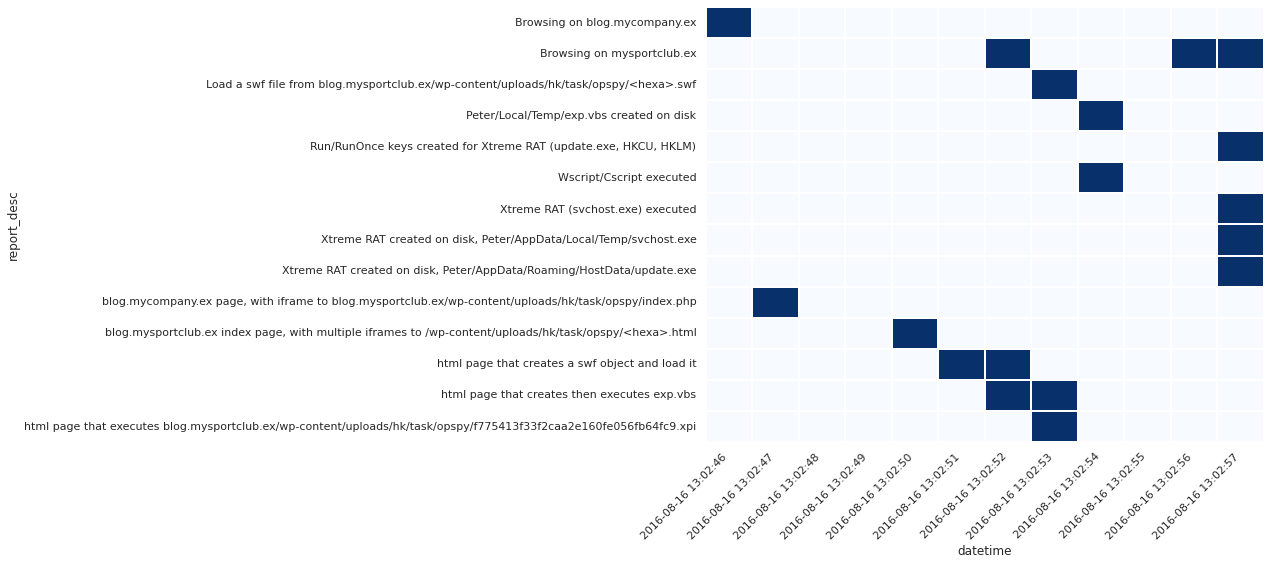

In [99]:
f_report = df['to_keep'] == True
f_start = df.index >= '2016-08-16 13:02'
f_end = df.index < '2016-08-16 13:03'

df_report = df[f_report & f_start & f_end]\
    .groupby([pd.Grouper(freq='S'), 'report_desc'])\
    .size()\
    .unstack()\
    .asfreq('S')\
    .fillna(0)\
    .gt(0)\
    .astype(int)

df_report.index = df_report.index.to_period('S')
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_report.T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, linewidth=0.1)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

## XTreme RAT C2

According to the literature on Xtreme RAT, there is a config file, usually written in AppData/Roaming/Microsoft/Windows (defense evasion here), encrypted with RC4. 

We check the files created between the download of the RAT and its first execution.

In [100]:
date_xtreme_downloaded = df_beginning['raw'].str.lower().str.contains('3568226350[1].exe', regex=False).idxmax()
date_xtreme_executed = df_beginning['raw'].str.lower().str.contains('temp\svchost.exe', regex=False).idxmax()
df_refined = df.loc[date_xtreme_downloaded:date_xtreme_executed]

f_created = df_refined['file_created'] == True
f_not_cache = ~df_refined['raw'].str.lower().str.contains('z0l7z3kd.default/cache2/entries')

df_refined.loc[f_created & f_not_cache, ['raw']]

,raw
datetime,
2016-08-16 13:02:56+00:00,C:/Users/Peter/AppData/Local/Microsoft/Windows/INetCache/IE/R81B6P1C/3568226350[1].exe ($FILE_NAME)
2016-08-16 13:02:57+00:00,C:/Users/Peter/AppData/Roaming/Microsoft/Windows/GhCtxq8t.cfg ($FILE_NAME)
2016-08-16 13:02:57+00:00,C:/Users/Peter/AppData/Local/Temp/svchost.exe ($FILE_NAME)
2016-08-16 13:02:57+00:00,C:/Users/Peter/AppData/Roaming/HostData ($FILE_NAME)
2016-08-16 13:02:57+00:00,C:/Users/Peter/AppData/Roaming/HostData/update.exe ($FILE_NAME)


We have one candidate: AppData/Roaming/Microsoft/Windows/GhCtxq8t.cfg.
It's indeed the configuration file: decrypting it, we learn that the RAT gets installed in AppData/Roaming/HostData/update.exe, and will contact back 36.98.102.89. 
This explains the URL found earlier in IE cache: http[:]//36.98.102.89:12345/1234567890.functions.

In [101]:
answers['vector'].extend([
    'Xtreme RAT configuration file: GhCtxq8t.cfg',
])
answers['c2'].extend([
    'Xtreme RAT C2 is 36.98.102.89 (config file)',
    'Xtreme RAT sends requests http://36.98.102.89:12345/1234567890.functions',
])

We now look for events referring to these new indicators and save the relevant ones for the report.

In [102]:
new_indicators = ['ghctxq8t', '36.98.102.89']

In [103]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_created = df['file_created'] == True
f_not_mft = df['source'] != 'mft'

#df.loc[(f_indicators & (f_not_mft) |  f_created), 'source'].value_counts().to_frame()
s_keywords = df.loc[(f_indicators & (f_not_mft) |  f_created), 'raw']\
    .str.lower().str.extract('('+ '|'.join(new_indicators) + ')', expand=False)

df[(f_indicators & (f_not_mft) |  f_created)]\
    .groupby([s_keywords, 'source']).size()\
    .unstack()\
    .fillna(0)\
    .astype(int)\
    .style.highlight_between(left=0, inclusive='right', color='skyblue')

source,mft,plaso_esedb/msie_webcache
raw,,
36.98.102.89,0,3
ghctxq8t,2,0


In [104]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))
f_created = df['file_created'] == True
f_browsing = df['source'].str.lower().str.contains('msie_webcache')

df.loc[f_indicators & f_created, 'to_keep'] = True
df.loc[f_indicators & f_created, 'report_desc'] = 'Xtreme RAT config file created'
df.loc[f_indicators & f_created, 'mitre_tactic'] = 'Resource Development'

df.loc[f_indicators & f_browsing, 'to_keep'] = True
df.loc[f_indicators & f_browsing, 'report_desc'] = 'Xtreme RAT sends request to 36.98.102.89'
df.loc[f_indicators & f_browsing, 'mitre_tactic'] = 'Command and Control'

In [105]:
indicators += new_indicators

## Lateral movement
We previously noticed the presence of plink.exe and pscp.exe in attacker toolbox, as well as some executions of them. 
These tools are respectively used to connect to a remote host (Putty Link) and to transfer data from/to a remote host (Putty Secure Copy). 
Both of these tools are tight to Putty, we look for artifacts containing it. 

In [106]:
f_plink_pscp = df['report_desc'].str.lower().str.contains('plink.exe|pscp.exe')
f_putty = df['raw'].str.lower().str.contains('putty')
df.loc[f_plink_pscp | f_putty, ['source', 'raw', 'report_desc']]

,source,raw,report_desc
datetime,,,
2016-08-16 14:10:49+00:00,log_prefetch,"Prefetch [PLINK.EXE] was executed - run count 6 path hints: \USERS\PETER\APPDATA\ROAMING\EPUPDATE\SSH\PLINK.EXE hash: 0xF57F43AD volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]",plink.exe executed
2016-08-16 14:10:51+00:00,mft,C:/Users/Peter/AppData/Local/PUTTY.RND,
2016-08-16 14:10:51+00:00,mft,C:/Users/Peter/AppData/Local/PUTTY.RND ($FILE_NAME),
2016-08-16 14:11:20+00:00,log_prefetch,"Prefetch [PLINK.EXE] was executed - run count 6 path hints: \USERS\PETER\APPDATA\ROAMING\EPUPDATE\SSH\PLINK.EXE hash: 0xF57F43AD volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]",plink.exe executed
2016-08-16 14:17:45+00:00,log_prefetch,"Prefetch [PLINK.EXE] was executed - run count 6 path hints: \USERS\PETER\APPDATA\ROAMING\EPUPDATE\SSH\PLINK.EXE hash: 0xF57F43AD volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]",plink.exe executed
2016-08-16 14:20:44+00:00,log_prefetch,"Prefetch [PLINK.EXE] was executed - run count 6 path hints: \USERS\PETER\APPDATA\ROAMING\EPUPDATE\SSH\PLINK.EXE hash: 0xF57F43AD volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]",plink.exe executed
2016-08-16 14:22:45+00:00,log_prefetch,"Prefetch [PLINK.EXE] was executed - run count 6 path hints: \USERS\PETER\APPDATA\ROAMING\EPUPDATE\SSH\PLINK.EXE hash: 0xF57F43AD volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]",plink.exe executed
2016-08-16 14:23:31+00:00,log_prefetch,"Prefetch [PLINK.EXE] was executed - run count 6 path hints: \USERS\PETER\APPDATA\ROAMING\EPUPDATE\SSH\PLINK.EXE hash: 0xF57F43AD volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]",plink.exe executed
2016-08-16 14:47:12+00:00,log_prefetch,"Prefetch [PSCP.EXE] was executed - run count 3 path hints: \USERS\PETER\APPDATA\ROAMING\EPUPDATE\SSH\PSCP.EXE hash: 0x6CA95035 volume: 1 [serial number: 0xB6E74FF7, device path: \VOLUME{01d1dde0e6d6158b-b6e74ff7}]",pscp.exe executed


We observe the creation of putty.rnd at the first execution of plink.exe. 
This is not surprising but does not contain further insights for us (the file is a list of random seeds used to establish the SSH connection). 

In the artifacts used for this write-up, the registry keys were not all extracted. 
Including them like for a real investigation would have pointed the modification of the HKCU/Software/SimonTatham/PuTTY/SshHostKeys key at 14h11, adding the value "rsa2@22:192.168.5.10" to the existing ones. 
This indicates the very first connection from the subject to 192.168.5.10, and we discovered previsouly that the IP is a DNS server that the threat actor scanned.

In [107]:
answers['lateral_movement'].append('plink/pscp used to connect to 192.168.5.10 the DNS server (Putty HKCU key)')

## Data Exfiltration
This part is often the most difficult as no artifacts clearly points to the data exfiltrated. 
Nevertheless, we have some information:
- the threat actor could literally access any file on the disk thanks to local admin privileges of the account Peter
- the threat actor accessed the internal network from Xtreme RAT installed on the subject
- we also know of pscp use to connect to the DNS server

Hence, the analysis of the DNS server is mandatory to get the full picture as data might have been exfiltrated from it. 
We also consider that any file on the subject is compromised.

We can still measure the data volume exchanged with the threat actor.

In [108]:
f_traffic = df['bytes_sent'] > 0
f_report = df['to_keep'] == True
f_rat = df['report_desc'].str.lower().str.contains('xtreme')
(df.loc[f_traffic & f_report & f_rat, ['bytes_sent', 'bytes_received']].sum()/2**20).to_frame(name='total_mb')

,total_mb
bytes_sent,1109.374292
bytes_received,35.529840


In [109]:
answers['data'].append('Xtreme RAT: 1.1GB sent to attacker, 35.5MB received')

We plot the occurences along the time to get a detailed view of the connections.

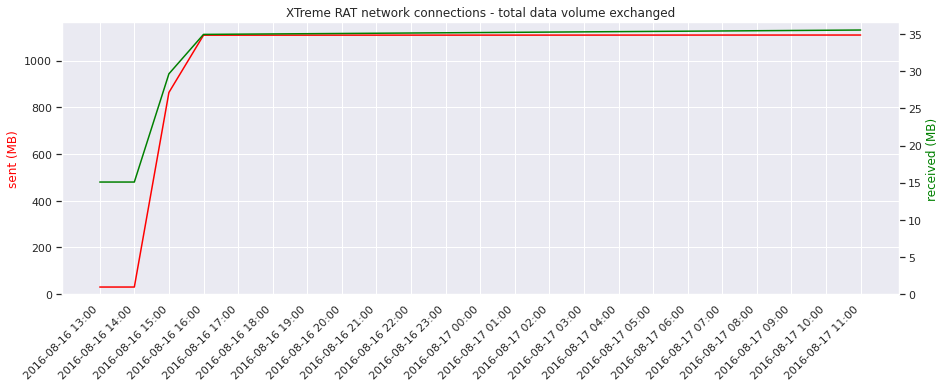

In [110]:
# filter on Xtreme RAT connections
f_traffic = df['bytes_sent'] > 0
f_report = df['to_keep'] == True
f_rat = df['report_desc'].str.lower().str.contains('xtreme')
df_volume = df.loc[f_traffic & f_report & f_rat, ['bytes_sent', 'bytes_received']]

# resample every hour (SRUM db) and change unit to MB
df_volume['sent_mb'] = df_volume['bytes_sent']/2**20
df_volume['received_mb'] = df_volume['bytes_received']/2**20
df_volume = df_volume.drop(columns=['bytes_sent', 'bytes_received'])
df_volume = df_volume.resample('1H').sum().cumsum()
df_volume.index = df_volume.index.to_period('T')

# create the bar plots with a shared X axis
fig, ax_sent = plt.subplots(figsize=(15, 5))
ax_received = ax_sent.twinx()
ax_sent.set_title('XTreme RAT network connections - total data volume exchanged')
sns.lineplot(x=df_volume.index.astype('str'), y=df_volume['sent_mb'], color='red', ax=ax_sent)
sns.lineplot(x=df_volume.index.astype('str'), y=df_volume['received_mb'], color='green', ax=ax_received)

# arrange the annotations
ax_sent.set_xlabel('')
ax_sent.set_ylabel('sent (MB)', color='red')
ax_received.set_ylabel('received (MB)', color='green')
ax_received.grid(None)
ax_sent.set_ylim(ymin=0)
ax_received.set_ylim(ymin=0)
_ = ax_sent.set_xticklabels(df_volume.index.astype('str'), rotation=45, ha='right')


## Conclusion on the Case

Based on the artifacts loaded, we could reconstruct the chain of events from the initial to the executions post-compromise (toolbox, persistence, lateral movements, ...). 

We summarize them with few visualizations, that we can save (right click and save image):
- global view with the MITRE tactics
- zoom on the beginning of the attack
- the heart of the attack
- the network connections

For the report, we also export as csv:
- the timeline, with all useful information (source, raw event, description, mitre tactic, measurement if any)
- our notes
- the list of indicators identified
- the data volume exchanged with the threat actor through XTreme RAT

In [111]:
# save the notes
display_answers(answers).to_csv('case_1/notes.csv', encoding='utf8', index=False)

# save the timeline
f_report = df['to_keep'] == True
columns = [
    'source', 'mitre_tactic', 'report_desc',
    'file_size_mb', 'bytes_received', 'bytes_sent', 'evtx_info',
    'timestamp_desc', 'raw',
]
df.loc[f_report, columns].replace(r'\n',' ', regex=True).to_csv('case_1/timeline.csv', encoding='utf8', index=True)

# save the indicators
pd.DataFrame(indicators).to_csv('case_1/iocs.txt', encoding='utf8', index=False, header=False)

# save the Xtreme RAT connections
f_traffic = df['bytes_sent'] > 0
f_report = df['to_keep'] == True
f_rat = df['report_desc'].str.lower().str.contains('xtreme')
df.loc[f_traffic & f_report & f_rat, ['bytes_sent', 'bytes_received']]\
    .to_csv('case_1/xtreme_rat_data_volume.csv', encoding='utf8')


### Global visualization

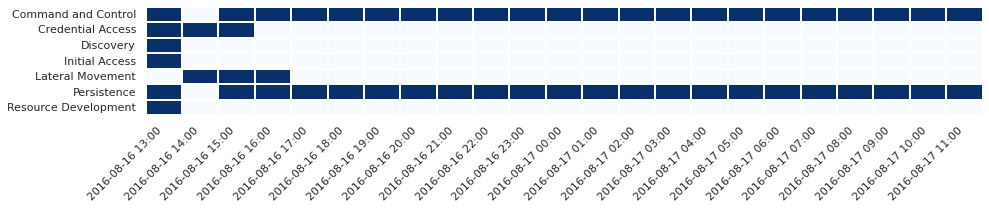

In [112]:
f_report = df['to_keep'] == True

df_report = df[f_report]\
    .groupby([pd.Grouper(freq='H'), 'mitre_tactic'])\
    .size()\
    .unstack()\
    .asfreq('H')\
    .fillna(0)\
    .gt(0)\
    .astype(int)

df_report.index = df_report.index.to_period('T')
fig, ax = plt.subplots(figsize=(15, 2))
sns.heatmap(df_report.T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, linewidth=0.1)
ax.set_xlabel('')
ax.set_ylabel('')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

### Beginning of the attack

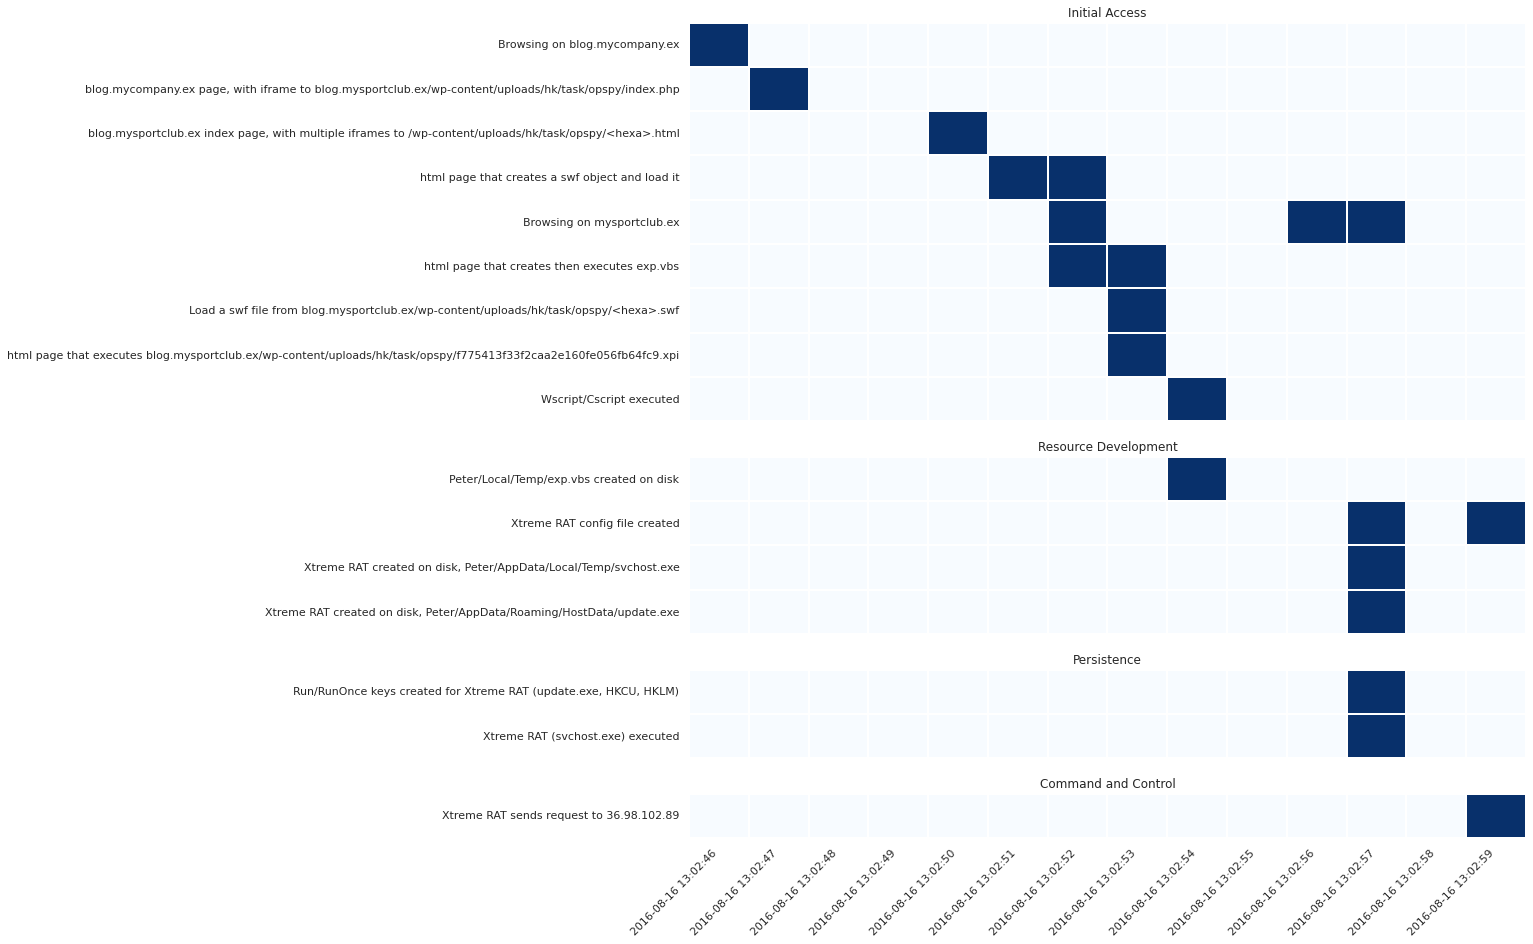

In [113]:
f_report = df['to_keep'] == True
f_end = df.index < '2016-08-16 13:03'

df_report = df[f_report & f_end]
tactics = df_report['mitre_tactic'].unique()
df_report = df_report\
    .groupby([pd.Grouper(freq='S'), 'mitre_tactic', 'report_desc'])\
    .size()\
    .unstack(['mitre_tactic', 'report_desc'])\
    .asfreq('S')\
    .fillna(0)\
    .gt(0)\
    .astype(int)
df_report.index = df_report.index.to_period('S')

total_events = df_report.T.index.size
ratios = []
for tactic in tactics:
    ratios.append(df_report[tactic].T.size/total_events)
fig, axs = plt.subplots(len(tactics), figsize=(15, 15), gridspec_kw={'height_ratios': ratios}, sharex=True)

for i in range(0, len(tactics)):
    tactic = tactics[i]
    axs[i].set_title(tactic)
    sns.heatmap(df_report[tactic].T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, linewidth=0.1, ax=axs[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=0)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')

### Heart of the attack

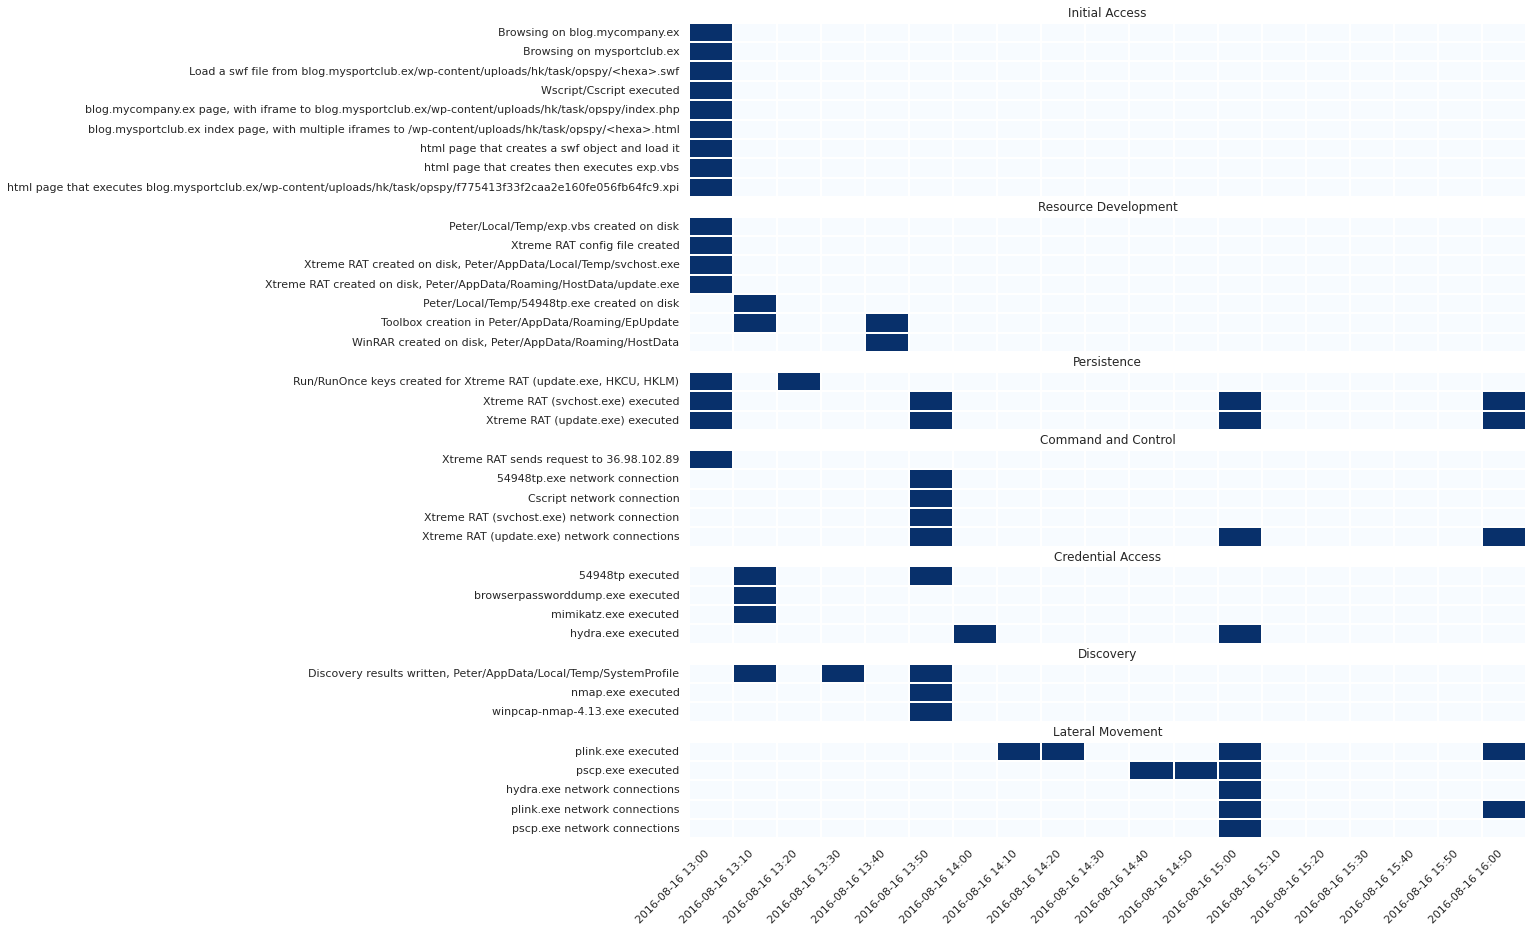

In [114]:
f_report = df['to_keep'] == True
f_end = df.index < '2016-08-16 17:00'

df_report = df[f_report & f_end]
tactics = df_report['mitre_tactic'].unique()
df_report = df_report\
    .groupby([pd.Grouper(freq='10T'), 'mitre_tactic', 'report_desc'])\
    .size()\
    .unstack(['mitre_tactic', 'report_desc'])\
    .asfreq('10T')\
    .fillna(0)\
    .gt(0)\
    .astype(int)
df_report.index = df_report.index.to_period('T')

total_events = df_report.T.index.size
ratios = []
for tactic in tactics:
    ratios.append(df_report[tactic].T.size/total_events)
fig, axs = plt.subplots(len(tactics), figsize=(15, 15), gridspec_kw={'height_ratios': ratios}, sharex=True)

for i in range(0, len(tactics)):
    tactic = tactics[i]
    axs[i].set_title(tactic)
    sns.heatmap(df_report[tactic].T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, linewidth=0.1, ax=axs[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=0)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')

### End of the attack

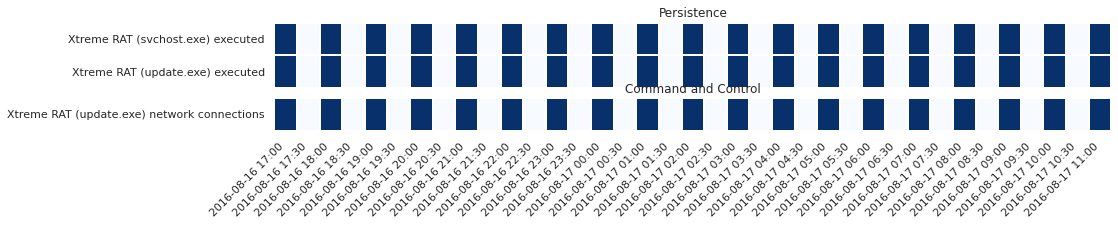

In [115]:
f_report = df['to_keep'] == True
f_end = df.index >= '2016-08-16 17:00'

df_report = df[f_report & f_end]
tactics = df_report['mitre_tactic'].unique()
df_report = df_report\
    .groupby([pd.Grouper(freq='30T'), 'mitre_tactic', 'report_desc'])\
    .size()\
    .unstack(['mitre_tactic', 'report_desc'])\
    .asfreq('30T')\
    .fillna(0)\
    .gt(0)\
    .astype(int)
df_report.index = df_report.index.to_period('T')

total_events = df_report.T.index.size
ratios = []
for tactic in tactics:
    ratios.append(df_report[tactic].T.size/total_events)
fig, axs = plt.subplots(len(tactics), figsize=(15, 2), gridspec_kw={'height_ratios': ratios}, sharex=True)

for i in range(0, len(tactics)):
    tactic = tactics[i]
    axs[i].set_title(tactic)
    sns.heatmap(df_report[tactic].T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, linewidth=0.1, ax=axs[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=0)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')

### Connections to C2

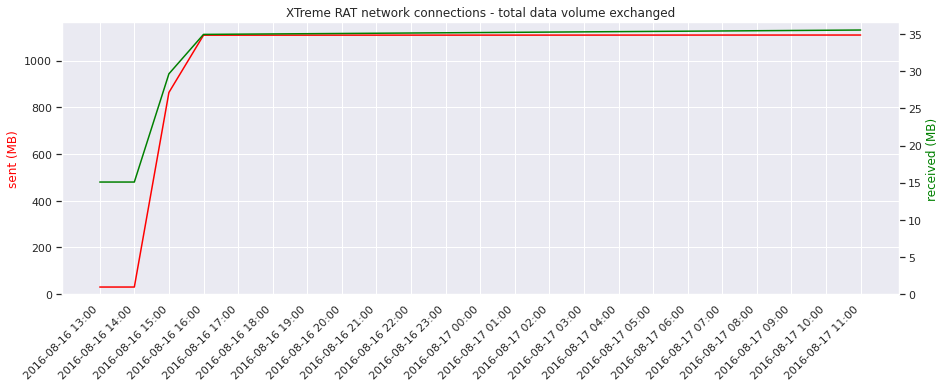

In [116]:
# filter on Xtreme RAT connections
f_traffic = df['bytes_sent'] > 0
f_report = df['to_keep'] == True
f_rat = df['report_desc'].str.lower().str.contains('xtreme')
df_volume = df.loc[f_traffic & f_report & f_rat, ['bytes_sent', 'bytes_received']]

# resample every hour (SRUM db) and change unit to MB
df_volume['sent_mb'] = df_volume['bytes_sent']/2**20
df_volume['received_mb'] = df_volume['bytes_received']/2**20
df_volume = df_volume.drop(columns=['bytes_sent', 'bytes_received'])
df_volume = df_volume.resample('1H').sum().cumsum()
df_volume.index = df_volume.index.to_period('T')

# create the bar plots with a shared X axis
fig, ax_sent = plt.subplots(figsize=(15, 5))
ax_received = ax_sent.twinx()
ax_sent.set_title('XTreme RAT network connections - total data volume exchanged')
sns.lineplot(x=df_volume.index.astype('str'), y=df_volume['sent_mb'], color='red', ax=ax_sent)
sns.lineplot(x=df_volume.index.astype('str'), y=df_volume['received_mb'], color='green', ax=ax_received)

# arrange the annotations
ax_sent.set_xlabel('')
ax_sent.set_ylabel('sent (MB)', color='red')
ax_received.set_ylabel('received (MB)', color='green')
ax_received.grid(None)
ax_sent.set_ylim(ymin=0)
ax_received.set_ylim(ymin=0)
_ = ax_sent.set_xticklabels(df_volume.index.astype('str'), rotation=45, ha='right')


## Conclusion on Pandas

With this library, we could:
- zoom back and forth in the events as a whole (__df__ versus __df_refined__ for example) without altering the original data
- keep the global view of the attack all along our analysis by visualizing the timeline 
- navigate across all heterogeneous raw events (unstructured string, xml) at a time to identify all occurences of an indicator
- filter easily based on a column, while keeping the others
- supply on the go the timeline (__to_keep = True__) and our notes (__answers__), in the same place
- check our progress without scrolling by just displaying the timeline or our notes
- build a comprehensive timeline, with the source of our evidences, and with the associated raw events, all in the same place
- get clear visualizations of the chain of events, understandable for non-technical persons
- save our results and visualizations in files

In addition, the progressive toughts and results of an analyst are at the same place, so that:
- an extra pair of eyes can validate the findings
- when multiple analysts worked on a case, timelines can be merged from the saved csv to generate the global visualizations
- no need to agree on a common phrasing, the raw events are available to understand

Lastly, we often reuse the same visualizations. 
We can abstract them in functions and build our own library:
- extract the number of files created under a given path and for a given depth to mine a noisy MFT
- from a set of indicators, create the pivot table with the data source that observed them
- visualize the timeline, as a whole, or on a particular period
- visualize the data volume exchanged

I feel it simplifies the exploration by providing a handrail, from which analyst can select puzzle pieces to analyze deeper (file content on the disk, artifacts not loaded/parsed, ...).